# Introduction to Generalized Linear Models using [Pynapple](https://pynapple.org) and [NeMos](https://nemos.readthedocs.io/en/latest/)

:::{card}
Authors: Camila Maura, Edoardo Balzani & Guillaume Viejo 
:::

In this notebook, we will use [**Pynapple**](https://pynapple.org) and [**NeMos**](https://nemos.readthedocs.io/en/latest/) packages (supported by the [Flatiron Institute](https://neurorse.flatironinstitute.org)), to model spiking neural data using [Generalized Linear Models (GLM)](https://en.wikipedia.org/wiki/Generalized_linear_model). We will explain what GLMs are and which are their components, then use **Pynapple** and **NeMos** python packages to preprocess real data from the Primary Visual Cortex (VISp) of mice, and use a GLM model to predict spiking neural data as a function of passive visual stimuli. We will also show how, if you have recordings from a large population of neurons simultaneously, you can build connections between the neurons into the GLM in the form of coupling filters.

We will be analyzing data from the [Visual Coding - Neuropixels dataset](https://portal.brain-map.org/circuits-behavior/visual-coding-neuropixels), published by the Allen Institute. This dataset uses [extracellular electrophysiology probes](https://www.nature.com/articles/nature24636) to record spikes from multiple regions in the brain during passive visual stimulation. For simplicity, we will focus on the activity of neurons in the visual cortex (VISp) during passive exposure to full-field flashes of color either black (coded as "-1.0") or white (coded as "1.0") in a gray background.

## Background on GLMs

A GLM is a regression model which trains a filter to predict a value (output) as it relates to some other variable (or input). In the neuroscience context, we can use a particular type of GLM to predict spikes: the linear-nonlinear-Poisson (LNP) model. This type of model receives one or more inputs and then sends them through a linear  "filter" or transformation, passes said transformation through a nonlinearity to get the firing rate and uses that firing rate as the mean of a Poisson distribution to generate spikes. We will go through each of these steps one by one:

![LNP model schematic](../../data/images/lnp_model.png)

<div style="text-align: center;">

  LNP model schematic. Modified from {cite:t}`pillowSpatiotemporalCorrelationsVisual2008` 
   <span id="cite1a"></span><a href="#ref1">[1a]</a>.
</div>

1. Sends the inputs through a linear "filter" or transformation
     
    The inputs (also known as "predictors" or "filters") are first passed through a linear transformation:
    
    $$
    \begin{aligned}
    L(X) = WX + c
    \end{aligned}
    $$

    Where $X$ is the input (in matrix form), $W$ is a matrix and $c$ is a vector (intercept).

    $L$ scales (makes bigger or smaller) or shifts (up or down) the input. When there is zero input, this is equivalent to changing the baseline rate of the neuron, which is how the intercept should be interpreted. So far, this is the same treatment of an ordinary linear regression. 

2. Passes the transformation through a nonlinearity to get the firing rate.
    
    The aim of a LNP model is to predict the firing rate of a neuron and use it to generate spikes, but if we were only to keep $L(X)$ as it is, we would quickly notice that we could obtain negative values for firing rates, which makes no sense! This is what the nonlinearity part of the model handles: by passing the linear transformation through an exponential function, it is assured that the resulting firing rate will always be non-negative. 

    As such, the firing rate in a LNP model is defined:

    $$
    \begin{aligned}
    \lambda =  exp(L(X))
    \end{aligned}
    $$

    where $\lambda$ is a vector containing the firing rates corresponding to each timepoint.

:::{admonition} A note on nonlinearity
:class: info
:class: dropdown


In **NeMoS**, the nonlinearity is kept fixed. We default to the exponential, but a small number of other choices, such as soft-plus, are allowed. The allowed choices guarantee both the non-negativity constraint described above, as well as convexity, i.e. a single optimal solution. In principle, one could choose a more complex nonlinearity, but convexity is not guaranteed in general.
:::

:::{admonition} What is the difference between a "link function" and the "nonlinearity"?
:class: info
:class: dropdown

The link function states the relationship between the linear predictor and the mean of the distribution function. If $g$ is a link function, $L(⋅)$ is the linear predictor and $\lambda$ the mean of the distribution function:

$$
\begin{aligned}
g(\lambda) = L(⋅)
\end{aligned}
$$

$$
\begin{aligned}
\lambda = g^{-1}(L(⋅))
\end{aligned}
$$

the "nonlinearity" is the name for the inverse of the link function $g^{-1}(⋅)$.

:::

3. Uses the firing rate as the mean of a Poisson distribution to generate spikes

    In this type of GLM, each spike train is modeled as a sample from a Poisson distribution whose mean is the firing rate — that is, the output of the linear-nonlinear components of the model.

    Spiking is a stochastic process. This means that a given firing rate can lead to many different possible spike trains. Since the model could generate an infinite number of spike train realizations, how do we evaluate how well it explains the single observed spike train? We do this by computing the log-likelihood: it quantifies how likely it is to observe the actual spike train given the predicted firing rate. If $ y(t) $ is the observed spike count and $ \lambda(t) $ is the predicted firing rate at time $ t $, then the log-likelihood at time $ t $:

    $$
    \log P(y(t) \mid \lambda(t)) = y(t)\log\lambda(t) - \lambda(t) -\log(y(t)!)
    $$

    However, the term $ -\log(y(t)!) $ does not depend on $ \lambda $, and therefore is constant with respect to the model. As a result, it is usually dropped during optimization, leaving us with the simplified log-likelihood:

    $$
    \log P(y(t) \mid \lambda(t)) = y(t) \log \lambda(t) - \lambda(t)
    $$

    This forms the loss function for LNPs. In practice, we aim to maximize this log-likelihood, which is equivalent to minimizing the negative log-likelihood — that is, finding the firing rate $\lambda(t)$ that makes the observed spike train as likely as possible under the model.


:::{admonition} Why using GLMs?
:class: info
:class: dropdown

1. Why not just use linear regression? Because neural data breaks its key assumptions. Linear regression expects normally distributed data with constant variance, but spike counts are non-Gaussian. Even more problematic, neural variability isn't constant: neurons that fire more frequently also tend to be more variable. This violates the homoscedasticity assumption that's fundamental to linear regression, making GLMs a much more suitable framework for modeling neural activity.

2. GLMs are as easy to fit as linear regression! The objective function (negative log-likelihood) of GLMs with canonical link functions (such as log link which we are using here) is convex, which means there is one local minimum and no local maxima, ensuring convergence to the right answer.
:::

:::{admonition} More resources on GLMs
:class: seealso
:class: dropdown

If you would like to learn more about GLMs, you can refer to:

- [Nemos GLM tutorial](https://nemos.readthedocs.io/en/latest/background/plot_00_conceptual_intro.html): for a bit more detailed explanation of all the components of a GLM within the **NeMos** framework, as well as some nice visualizations of all the steps of the input transformation!
- [Introduction to GLM - CCN software worshop by the Flatiron Institute](https://flatironinstitute.github.io/neurorse-workshops/workshops/jan-2025/branch/main/full/day2/current_injection.html): for a step by step example of using GLMs to fit the activity of a single neuron in VISp under current injection.
- [Neuromatch Academy GLM tutorial](https://compneuro.neuromatch.io/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Tutorial1.html): for a bit  more detailed explanation of the components of a GLM, slides and some coding exercises to ensure comprehension.
- [Jonathan Pillow's COSYNE tutorial](https://www.youtube.com/watch?v=NFeGW5ljUoI&t=4230s): for a longer tutorial of all of the components of a GLM, as well as different types of GLM besides LNP
:::

## Environment setup and library imports

In [761]:
# Install requirements for the databook
'''
try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .
'''

'\ntry:\n    from databook_utils.dandi_utils import dandi_download_open\nexcept:\n    !git clone https://github.com/AllenInstitute/openscope_databook.git\n    %cd openscope_databook\n    %pip install -e .\n'

In [ ]:
# Import libraries
import seaborn as sns
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import pynapple as nap
import nemos as nmo

In [ ]:
# Imports for ease of visualization
import warnings
import matplotlib as mpl
warnings.filterwarnings("ignore")
from matplotlib.ticker import MaxNLocator

# Parameters for plotting
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette="colorblind", font_scale=1.5, rc=custom_params)

## Download data

In [765]:
# Dataset information
dandiset_id = "000021"
dandi_filepath = "sub-726298249/sub-726298249_ses-754829445.nwb"
download_loc = "."

# Download using nemos
#io = nmo.fetch.download_dandi_data(dandiset_id, dandi_filepath)

Now that we have downloaded the data, it is very simple to open the dataset with **Pynapple**

In [766]:
data = nap.NWBFile(io.read(), lazy_loading=False)
nwb = data.nwb

print(data)

754829445
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                                               │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                                              │ TsGroup     │
│ static_gratings_presentations                      │ IntervalSet │
│ spontaneous_presentations                          │ IntervalSet │
│ natural_scenes_presentations                       │ IntervalSet │
│ natural_movie_three_presentations                  │ IntervalSet │
│ natural_movie_one_presentations                    │ IntervalSet │
│ gabors_presentations                               │ IntervalSet │
│ flashes_presentations                              │ IntervalSet │
│ drifting_gratings_presentations                    │ IntervalSet │
│ timestamps                                         │ Tsd         │
│ running_wheel_rotation                             │ Tsd         │
│ running_speed_end_time

:::{admonition} **Pynapple** objects
:class: info
:class: dropdown

When printing data, we can see four type of **Pynapple** objects:
- [```TsGroup```](https://pynapple.org/generated/pynapple.TsGroup.html#pynapple.TsGroup) : Dictionary-like object to group objects with different timestamps 
- [```IntervalSet```](https://pynapple.org/generated/pynapple.IntervalSet.html#pynapple.IntervalSet) : A class representing a (irregular) set of time intervals in elapsed time, with relative operations
- [```Tsd```](https://pynapple.org/generated/pynapple.Tsd.html#pynapple.Tsd) : 1-dimensional container for neurophysiological time series - provides standardized time representation, plus various functions for manipulating times series.
- [```TsdFrame```](https://pynapple.org/generated/pynapple.TsdFrame.html#pynapple.TsdFrame) : Column-based container for neurophysiological time series

To learn more, please refer to the [**Pynapple** documentation](https://pynapple.org)
:::

## Extraction, preprocessing and stimuli revision

### Extracting spiking data

We have a lot of information in ```data```, but we are interested in the units.

(it might take a while the first time that you run this - it's okay! the dataset is quite big)

In [767]:
units = data["units"]

# See the columns
print(f"columns : {units.metadata_columns}")

# See the dataset
print(units)

columns : ['rate', 'spread', 'velocity_below', 'silhouette_score', 'firing_rate', 'd_prime', 'nn_hit_rate', 'waveform_duration', 'amplitude', 'cluster_id', 'snr', 'local_index', 'peak_channel_id', 'PT_ratio', 'presence_ratio', 'max_drift', 'cumulative_drift', 'repolarization_slope', 'waveform_halfwidth', 'amplitude_cutoff', 'nn_miss_rate', 'quality', 'velocity_above', 'isolation_distance', 'l_ratio', 'recovery_slope', 'isi_violations']
Index      rate      spread    velocity_below    silhouette_score    firing_rate    d_prime    nn_hit_rate    ...
---------  --------  --------  ----------------  ------------------  -------------  ---------  -------------  -----
951763702  2.38003   30.0      nan               nan                 2.38           4.77       0.98           ...
951763707  0.01147   80.0      nan               0.03                0.01           3.48       0.0            ...
951763711  3.1503    50.0      nan               0.17                3.15           6.08       1.0    

Taking a closer look at the columns, we can see there is a lot of information we do not need. We are solely interested in predicting the spiking activity from the neurons from VISp. Thus, we will remove the metadata from all columns except for rate, quality (to make sure we filter the bad-quality neurons) and peak_channel_id (this last one contains relevant information for brain area identification).

In [768]:
def drop_cols(cols_to_keep, data):
    cols_to_remove = [col for col in data.metadata_columns if col not in cols_to_keep]
    data.drop_info(cols_to_remove)
    
# Choose which columns to remove and remove them
cols_to_keep = ['rate', 'quality','peak_channel_id']
drop_cols(cols_to_keep,units)

# See the dataset
print(units)

Index      rate      peak_channel_id    quality
---------  --------  -----------------  ---------
951763702  2.38003   850135036          good
951763707  0.01147   850135036          noise
951763711  3.1503    850135038          good
951763715  6.53      850135038          good
951763720  2.00296   850135044          good
951763724  8.66233   850135044          noise
951763729  11.13402  850135044          noise
...        ...       ...                ...
951777559  0.02108   850139336          good
951777565  0.08143   850139526          noise
951777571  0.20088   850139738          good
951777576  0.01085   850139338          good
951777582  0.1457    850139622          good
951777593  0.0464    850139620          good
951777600  0.0621    850139642          good


Here we dont have the brain area information but we need it, so we need to do some preprocessing to extract brain area from the nwb object using the peak_channel_id metadata. Luckily, **Pynapple** stored the nwb object as well.

In [769]:
# Units and brain areas those units belong to are in two different places. 
# With the electrodes table, we can map units to their corresponding brain regions.
def get_unit_location(unit_id):
    """Aligns location information from electrodes table with channel id from the units table
    """
    return channel_probes[int(units[unit_id].peak_channel_id)]

channel_probes = {}
electrodes = nwb.electrodes

for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

# Add a new column to include location in our spikes TsGroup
units.brain_area = [channel_probes[int(ch_id)] for ch_id in units.peak_channel_id]

# Remove peak_channel_id because we already got the brain_area information
units.drop_info("peak_channel_id")

print(units)

Index      rate      quality    brain_area
---------  --------  ---------  ------------
951763702  2.38003   good       PoT
951763707  0.01147   noise      PoT
951763711  3.1503    good       PoT
951763715  6.53      good       PoT
951763720  2.00296   good       PoT
951763724  8.66233   noise      PoT
951763729  11.13402  noise      PoT
...        ...       ...        ...
951777559  0.02108   good       LP
951777565  0.08143   noise      DG
951777571  0.20088   good       VISpm
951777576  0.01085   good       LP
951777582  0.1457    good       CA1
951777593  0.0464    good       CA1
951777600  0.0621    good       CA1


### Extracting trial structure 

Mice were exposed to a series of stimuli (gabor patches, flashes, natural images, etc.), out of which we are exclusively interested in flashes presentation for this tutorial.

![visual_stimuli_set.png](../../data/images/visual_stimuli_set.png)

<div style="text-align: center;">

Visual stimuli set. Modified from {cite:t}`NeuropixelsWhitePaper2019` <span id="cite2"></span><a href="#ref2">[2]</a>.

</div>

During the flashes presentation trials, mice were exposed to white or black full-field flashes in a gray background, each lasting 250 ms, and separated by a 2 second inter-trial interval. In total, they were exposed to 150 flashes (75 black, 75 white).

In [770]:
# Extract flashes as an Interval Set object
flashes = data["flashes_presentations"]

# Remove unnecesary columns, similarly to above
cols_to_keep = ['color']
drop_cols(cols_to_keep, flashes)

print(flashes)

index    start           end             color
0        1285.600869922  1285.851080039  -1.0
1        1287.602559922  1287.852767539  -1.0
2        1289.604229922  1289.854435039  -1.0
3        1291.605889922  1291.856100039  -1.0
4        1293.607609922  1293.857807539  1.0
5        1295.609249922  1295.859455039  -1.0
6        1297.610959922  1297.861155039  1.0
...      ...             ...             ...
143      1571.840009922  1572.090212539  -1.0
144      1573.841669922  1574.091877539  1.0
145      1575.843359922  1576.093562539  1.0
146      1577.845019922  1578.095227539  -1.0
147      1579.846709922  1580.096915039  1.0
148      1581.848389922  1582.098595039  1.0
149      1583.850039922  1584.100247539  -1.0
shape: (150, 2), time unit: sec.


Create an object for white and a separate object for black flashes

In [771]:
flashes_white = flashes[flashes["color"] == "1.0"]
flashes_black = flashes[flashes["color"] == "-1.0"]

In [772]:
def plot_stimuli():
    n_flashes = 5
    n_seconds = 13
    offset = .5

    start = data["flashes_presentations"]["start"].min() - offset
    end = start + n_seconds

    fig, ax = plt.subplots(figsize = (17, 4))
    [ax.axvspan(s, e, color = "silver", alpha=.4, ec="black") for s, e in zip(flashes_white[:n_flashes].start, flashes_white[:n_flashes].end)]
    [ax.axvspan(s, e, color = "black", alpha=.4, ec="black") for s, e in zip(flashes_black[:n_flashes].start, flashes_black[:n_flashes].end)]

    plt.xlabel("Time (s)")
    plt.ylabel("Absent = 0, Present = 1")
    ax.set_title("Stimuli presentation")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.xlim(start-.1,end)
    plt.show()

And we can plot the stimuli

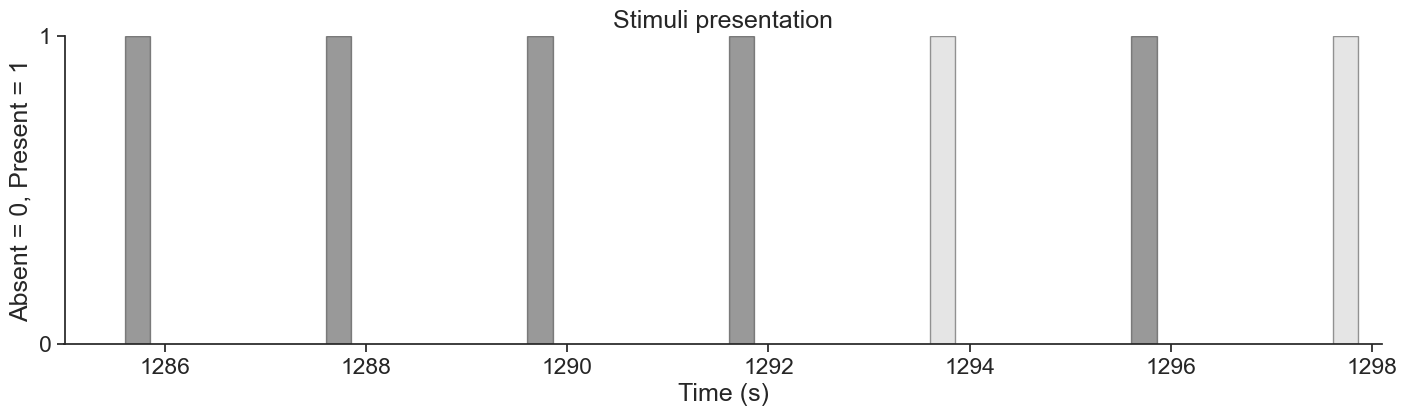

In [773]:
plot_stimuli()

To analyze how units' activity evolves around the time of stimulus presentation, we can extend each stimulus interval to include some time before and after the flash. Specifically, we add 500 ms before the flash onset and 500 ms after the flash offset. This gives us a window that captures pre-stimulus baseline activity and any delayed neural responses.

In [774]:
dt = .50 # 500 ms
start = flashes.start - dt # Start 500ms before stimulus presentation
end = flashes.end + dt # End 500ms after stimulus presentation

extended_flashes = nap.IntervalSet(start,end, metadata=flashes.metadata) 
print(extended_flashes)

index    start           end             color
0        1285.100869922  1286.351080039  -1.0
1        1287.102559922  1288.352767539  -1.0
2        1289.104229922  1290.354435039  -1.0
3        1291.105889922  1292.356100039  -1.0
4        1293.107609922  1294.357807539  1.0
5        1295.109249922  1296.359455039  -1.0
6        1297.110959922  1298.361155039  1.0
...      ...             ...             ...
143      1571.340009922  1572.590212539  -1.0
144      1573.341669922  1574.591877539  1.0
145      1575.343359922  1576.593562539  1.0
146      1577.345019922  1578.595227539  -1.0
147      1579.346709922  1580.596915039  1.0
148      1581.348389922  1582.598595039  1.0
149      1583.350039922  1584.600247539  -1.0
shape: (150, 2), time unit: sec.


This extended IntervalSet, ```extended_flashes```, will later allow us to restrict units' activity to the periods surrounding each flash stimulus.

We now create one object for white and another for black extended flashes.

In [775]:
extended_flashes_white = extended_flashes[extended_flashes["color"]=="1.0"]
extended_flashes_black = extended_flashes[extended_flashes["color"]=="-1.0"]

### Preprocessing spiking data

There are multiple reasons for filtering units. Here, we will use four criteria: brain area, quality of units, firing rate and responsiveness
1. Brain area: we are interested in analyzing VISp units for this tutorial
2. Quality: we will only select "good" quality units
3. Firing rate: overall, we want units with a firing rate larger than 2Hz around the presentation of stimuli
4. Responsiveness: to focus on meaningful signal, we will (1) exclude units that show no spiking activity during stimulus presentation. Moreover, for the purposes of the tutorial, we will (2) select the most responsive units (top 30%), and only use those for further analysis. We define responsiveness as the normalized difference between post stimulus and pre stimulus average firing rate.

:::{admonition} What does it mean for a unit to be of "good" quality?
:class: info
:class: dropdown

More information on unit quality metrics can be found in [Visualizing Unit Quality Metrics ](../visualization/visualize_unit_metrics.ipynb)

:::

In [776]:
# Filter units according criteria 1 & 2
units = units[
    (units["brain_area"]=="VISp") & 
    (units["quality"]=="good")
] 

# Restrict around stimuli presentation
units = units.restrict(extended_flashes) 

# Filter according to criterion 3
units = units[(units["rate"]>2.0)]

print(units)

Index      rate      quality    brain_area
---------  --------  ---------  ------------
951765440  2.32495   good       VISp
951765454  22.6523   good       VISp
951765460  2.29829   good       VISp
951765467  25.80912  good       VISp
951765485  22.96158  good       VISp
951765547  2.83687   good       VISp
951765552  5.69507   good       VISp
...        ...       ...        ...
951768823  5.40712   good       VISp
951768830  7.58276   good       VISp
951768835  5.60442   good       VISp
951768881  4.01534   good       VISp
951768894  4.2713    good       VISp
951769295  2.23963   good       VISp
951769344  2.91152   good       VISp


Now, to calculate responsiveness, we need to do some preprocessing to align units spiking timestamps with the onset of the stimuli repetitions, and then take an average over the them. For this, we will use the [```compute_perievent```](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent) function, which allows to re-center time series and timestamps around particular events and compute spikes trigger average.

In [777]:
# Set window of perievent 500ms before and after the start of the event
window_size = (-.250, .500) 

# Calculate perievent for white stimuli
# +50 because we added +.50 at beginning and end of stimulus
peri_white = nap.compute_perievent(timestamps = units,
                                        tref = nap.Ts(extended_flashes_white.start +.50), 
                                        minmax = window_size
)

# Calculate perievent for black stimuli
# +50 because we added +.50 at beginning and end of stimulus
peri_black = nap.compute_perievent(timestamps = units,
                                        tref = nap.Ts(extended_flashes_black.start +.50), 
                                        minmax = window_size
)

The output of the perievent is a dictionary of [```TsGroup```](https://pynapple.org/generated/pynapple.TsGroup.html#pynapple.TsGroup) objects, indexed by each unit ID.

:::{admonition} Will the output of ```compute_perievent``` always be a dictionary?
:class: info
:class: dropdown

No. In this case it is because the input was a ```TsGroup``` containing the spiking information of multiple units. Had it been a ```Ts/Tsd/TsdFrame/TsdTensor``` (only one unit), then the output of [```compute_perievent```](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent) would have been a ```TsGroup```.
For more information, please refer to [**Pynapple** documentation for processing perievents](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent).
:::

When we index an element of this dictionary, we retrieve the spike times aligned to stimulus onset for a single unit, across all repetitions of the stimulus. These spike times are centered around the stimulus within the specified ```window_size```. You’ll notice that the ```ref_times``` in the perievent output correspond exactly to the start times of the stimulus presentations!

In [778]:
# Let's select one unit
example_id = 951765485 
print(f"Number of trials: {len(peri_black[example_id])}\n ")

# And print it's rates
print(f"TsGroup of centered activity for unit {example_id}: \n {peri_black[example_id]}\n")

# Start times of black flashes presentation
print(f"black flashes start times: \n {flashes_black.starts}")

Number of trials: 75
 
TsGroup of centered activity for unit 951765485: 
 Index    rate      ref_times
-------  --------  -----------
0        18.66667  1285.6
1        18.66667  1287.6
2        12.0      1289.6
3        9.33333   1291.61
4        32.0      1295.61
5        20.0      1303.62
6        18.66667  1307.62
...      ...       ...
68       13.33333  1561.83
69       6.66667   1563.83
70       8.0       1565.83
71       12.0      1569.84
72       20.0      1571.84
73       12.0      1577.85
74       10.66667  1583.85

black flashes start times: 
 Time (s)
1285.600869922
1287.602559922
1289.604229922
1291.605889922
1295.609249922
1303.615919922
1307.619279922
...
1561.831629922
1563.833279922
1565.834999922
1569.838349922
1571.840009922
1577.845019922
1583.850039922
shape: 75


Let's inspect a bit further our TsGroup objects with the centered spikes. If we grab the FIRST element of ```peri_black[example_id]```, we would get the spike times centered around the FIRST presentation of stimulus.

In [779]:
print(peri_black[example_id][0])

Time (s)
-0.128226254
-0.12362626
0.070806812
0.132140063
0.223106608
0.252739902
0.270706544
0.305906497
0.308506494
0.330173131
0.401073036
0.434739658
0.455372963
0.471839608
shape: 14


Negative spike times are expected here because the spike times in ```peri_white``` and ```peri_black``` are aligned relative to stimulus onset. A negative time means the spike occurred before the stimulus was presented, while a positive time indicates the spike occurred after stimulus onset. This alignment allows us to analyze how neuronal activity changes around the time of stimulus presentation.

We can also visualize these aligned spike times to better understand the timing and rate of neural responses relative to the stimulus. This type of plot is known as a [Peri Event Time Histogram (PETH)](https://en.wikipedia.org/wiki/Peristimulus_time_histogram), and it shows how spiking activity is distributed around the stimulus onset. Let’s generate a PETH for the first 8 units to explore their response patterns.

In [780]:
def plot_raster_peth(peri_color, units, color_flashes, bin_size, smoothing=0.015):
    """
    Plot perievent time histograms (PETHs) and raster plots for multiple units.

    Parameters:
    -----------
    peri_color : dict
        Dictionary mapping unit names to binned spike count peri-stimulus data (e.g., binned time series).
    units : dict
        Dictionary of neural units, e.g., spike trains or trial-aligned spike events.
    color_flashes : str
        A label indicating the flash color condition ('black' or other), used for visual styling.
    bin_size : float
        Size of the bin used for spike count computation (in seconds).
    smoothing : float
        Standard deviation for Gaussian smoothing of the PETH traces.
    """

    # Layout setup: 7 columns (units), 2 rows (split vertically into PETH and raster plot)
    n_cols = 8
    n_rows = 2
    fig, ax = plt.subplots(n_rows, n_cols)
    fig.set_figheight(4)
    fig.set_figwidth(17)
    fig.tight_layout()

    # Use tab10 color palette for plotting different units
    colors = plt.cm.tab10.colors[:n_cols]

    # Extract unit names for iteration
    units_list = list(units.keys())[10:]

    start = 0
    end = int(n_rows / 2)  # Plot as many units as half the number of rows 
                            # each unit occupies 2 rows (one for peth and other for raster)

    for col in range(n_cols):
        for i, unit in enumerate(units_list[start:end]):
            u = peri_color[unit]
            line_color = colors[col]

            # Plot PETH (smoothed firing rate)
            ax[2*i, col].plot(
                (np.mean(u.count(0.01), 1) / bin_size).smooth(std=smoothing),
                linewidth=2,
                color=line_color
            )
            ax[2*i, col].axvline(0.0)  # Stimulus onset line
            span_color = "black" if color_flashes == "black" else "silver"
            ax[2*i, col].axvspan(0, 0.250, color=span_color, alpha=0.3, ec="black")  # Stim duration
            ax[2*i, col].set_xlim(-0.25, 0.50)
            ax[2*i, col].set_title(f'{unit}')

            # Plot raster
            ax[2*i+1, col].plot(u.to_tsd(), "|", markersize=1, color=line_color, mew=2)
            ax[2*i+1, col].axvline(0.0)
            ax[2*i+1, col].axvspan(0, 0.250, color=span_color, alpha=0.3, ec="black")
            ax[2*i+1, col].set_ylim(0, 75)
            ax[2*i+1, col].set_xlim(-0.25, 0.50)

            # Shift window for next units
            start += 1
            end += 1

    # Y-axis and title annotations
    ax[0, 0].set_ylabel("Rate (Hz)")
    ax[1, 0].set_ylabel("Trial")
    if n_rows > 2:
        ax[2, 0].set_ylabel("Rate (Hz)")
        ax[3, 0].set_ylabel("Trial")
    fig.text(0.5, 0.00, 'Time from stim(s)', ha='center')
    fig.text(0.5, 1.00, f'PETH & Spike Raster Plot - {color_flashes} flashes', ha='center')

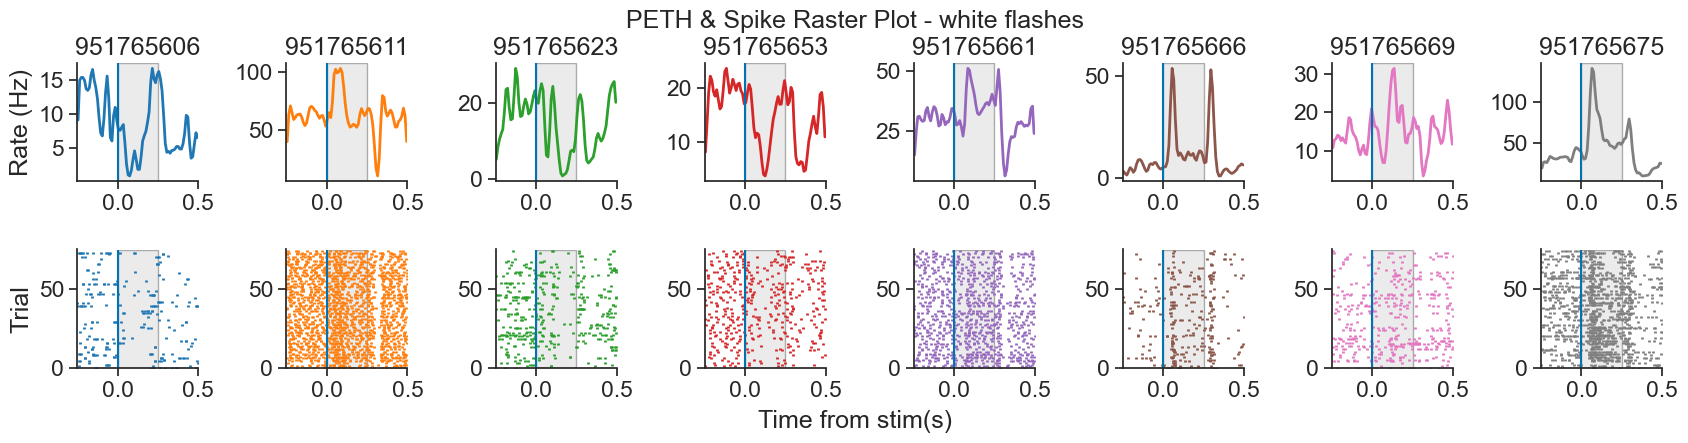

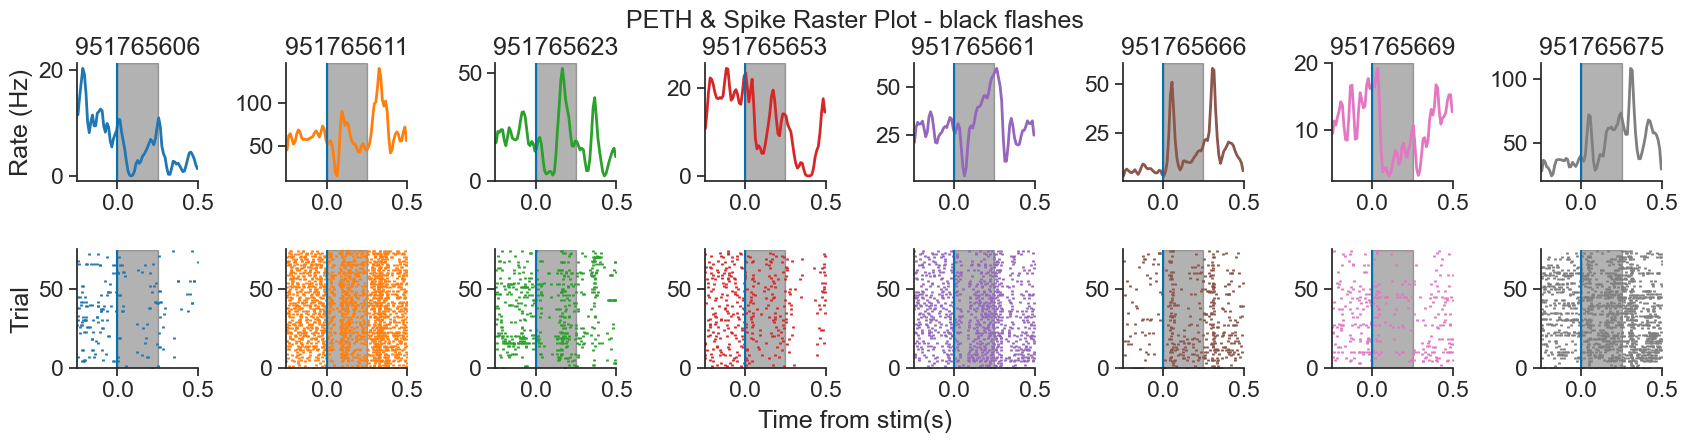

In [781]:
bin_size = 0.005 # Bin size

# Plot PETH and spike raster plots
plot_raster_peth(peri_white, units, "white", bin_size)
plot_raster_peth(peri_black, units, "black", bin_size)

:::{admonition} How to choose bin size?
:class: info
:class: dropdown

The ```bin_size``` determines the width of the time bins used to discretize the spike train. For example, a bin size of 0.005 means each second is divided into 200 bins of 5 milliseconds each. Smaller bin sizes provide higher temporal resolution, allowing you to detect rapid changes in firing rate, while larger bin sizes smooth out the activity over time but may obscure fine temporal dynamics.

In this tutorial, we use a bin size of 0.005, but there is no one-size-fits-all rule. The optimal bin size depends on the timescale of the neural activity you are modeling. For fast, precisely timed responses, a small bin size may be necessary. For slower or more sustained responses, larger bins may be more appropriate. Ultimately, it’s a modeling decision that should balance resolution with interpretability and noise.
:::

:::{admonition} Why does the peth plot look so smooth?
:class: info
:class: dropdown

We are using the [`smooth`](https://pynapple.org/generated/pynapple.Tsd.smooth.html#pynapple.Tsd.smooth) function from **Pynapple** to apply Gaussian smoothing to the perievent time series before plotting. This reduces trial-to-trial variability and emphasizes consistent temporal patterns in firing rate, making features like peaks or latency shifts easier to interpret—especially when spike trains are noisy or sparse.

In this tutorial, we use a Gaussian kernel with a standard deviation of 0.015 seconds.  

To convert the standard deviation from seconds to bins, we divide by the bin size:


$ 
\begin{aligned}
\frac{0.015}{0.005} = 3 \text{ bins} 
\end{aligned}
$ 

This means we smooth over approximately 3 bins.

For implementation details, refer to the [**Pynapple** documentation](https://pynapple.org/generated/pynapple.Tsd.smooth.html#pynapple.Tsd.smooth).

:::

In the plot above, we can see that some units (951765666, brown or 951765675, gray) are clearly more responsive than others (951765653, red), which are apparently not modulated by the flashes. Thus, it would make sense to take a subset of the neurons, the most responsive ones, and model those.

We will now calculate responsiveness for each neuron as the normalized difference between average firing rate before and after stimulus presentation, and select the most responsive ones for further analyses.

In [782]:
def get_responsiveness(perievents, bin_size):
    """Calculate responsiveness for each neuron. This is
    computer as:

    post_stim_av  : 
        Average firing rate during presentation (250ms) of stimulus across
        all instances of stimulus. 

    pre_stim_av :
        Average firing rate prior (250ms) to the presentation of stimulus
        accross all instances prior of stimulus. 

    responsiveness : 
        (post_stim_ave - pre_stim_av) / (post_stim_ave + pre_stim_av)

    Larger values indicate higher responsiveness to the stimuli.
        
    Parameters
    ----------
    perievents : TsGroup
        Contains perievent information of a subset of neurons
    bin_size : float
        Bin size for calculating spike counts

    Returns
    ----------   
    resp_array : np.array
        Array of responsiveness information.
    resp_dict : dict
        Dictionary of responsiveness information. Indexed by each neuron's,
        contains responsiveness, pre_stim_av and post_stim_av information

    """
    resp_dict = {}
    resp_array = np.zeros(len(perievents.keys()), dtype=float)

    for index,unit in enumerate(perievents.keys()):
        # Count the number of timestamps in each bin_size bin.
        peri_counts = perievents[unit].count(bin_size)

        # Get the firing rate
        peri_rate = peri_counts/bin_size

        # Compute average firing rate for each milisecond in the
        # the 250ms before stimulus presentation
        pre_stim = np.mean(peri_rate,1).restrict(nap.IntervalSet([-.25,0]))

        # Compute average firing rate for each milisecond in the
        # the 250ms after stimulus presentation
        post_stim = np.mean(peri_rate,1).restrict(nap.IntervalSet([0,.25]))

        pre_stim_av = np.mean(pre_stim)
        post_stim_av = np.mean(post_stim)
        responsiveness = (post_stim_av - pre_stim_av) / (post_stim_av + pre_stim_av)

        resp_dict[unit] = {
            "responsiveness": responsiveness,
            "pre_stim_av": pre_stim_av,
            "post_stim_av": post_stim_av,
        }
        resp_array[index] = responsiveness

    return resp_array, resp_dict

In [783]:
# Calculate responsiveness
responsiveness_white,_ = get_responsiveness(peri_white, bin_size)
responsiveness_black,_ = get_responsiveness(peri_black, bin_size)

# Add resposiveness as metadata for units
units.set_info(responsiveness_white=responsiveness_white)
units.set_info(responsiveness_black=responsiveness_black)

# See metadata
print(units)

Index      rate      quality    brain_area    responsiveness_white    responsiveness_black
---------  --------  ---------  ------------  ----------------------  ----------------------
951765440  2.32495   good       VISp          -0.14                   0.28
951765454  22.6523   good       VISp          -0.02                   0.02
951765460  2.29829   good       VISp          0.18                    0.0
951765467  25.80912  good       VISp          -0.17                   0.22
951765485  22.96158  good       VISp          0.15                    -0.39
951765547  2.83687   good       VISp          0.39                    0.0
951765552  5.69507   good       VISp          0.75                    0.81
...        ...       ...        ...           ...                     ...
951768823  5.40712   good       VISp          0.03                    0.4
951768830  7.58276   good       VISp          0.15                    0.47
951768835  5.60442   good       VISp          -0.07                  

Now I can remove units without any firing throughout the whole stimulus presentation, with 0 responsiveness and also keep the top 30% most responsive units for ongoing analyses

In [784]:
# Nan values ocurr when there is division by zero aka firing rate before + firing rate after = 0 
units = units[~np.isnan(units["responsiveness_black"]) & ~np.isnan(units["responsiveness_white"])]

# Remove units with 0 responsiveness
units = units[(np.abs(units["responsiveness_black"])>0.1 ) & (np.abs(units["responsiveness_white"]) >0.1)]

# Get threshold for top 30% most resopnsive
thresh_black = np.percentile(units["responsiveness_black"], 70)
thresh_white = np.percentile(units["responsiveness_white"], 70)

# Only keep units that are within the 30% most responsive for either black or white
units = units[(units["responsiveness_black"] > thresh_black) | (units["responsiveness_white"] > thresh_white)]


In [785]:
print(units)
print(f"\nRemaining units: {len(units)}")

Index      rate     quality    brain_area    responsiveness_white    responsiveness_black
---------  -------  ---------  ------------  ----------------------  ----------------------
951765552  5.69507  good       VISp          0.75                    0.81
951765666  5.01251  good       VISp          0.49                    0.44
951765732  4.31929  good       VISp          0.9                     1.0
951768154  2.82087  good       VISp          0.64                    0.89
951768278  3.43944  good       VISp          0.5                     0.66
951768285  4.06867  good       VISp          0.91                    0.3
951768291  2.77821  good       VISp          0.99                    0.5
...        ...      ...        ...           ...                     ...
951768586  2.82087  good       VISp          -0.59                   0.52
951768632  5.93503  good       VISp          0.16                    0.79
951768749  2.04767  good       VISp          0.94                    0.91
95176875

### Revision of stimuli and spiking data

Now that we have selected the units for our analyses, we can see how some of these neurons look in response to the stimuli in a PETH

In [786]:
def plot_peri_side_by_side(params,
                           bin_size,
                           smoothing = 0.015,
                           ):
    """Plot peri-event time histograms (PETHs) for white and black flashes side-by-side.

    Parameters
    ----------
    params : tuple
        (peri_white, peri_black) dictionaries with perievent spike data
    bin_size : float
        Width of bins for counting spikes (in seconds)
    smoothing: float
        Standard deviation of Gaussian smoothing kernel (in seconds)

     Returns
    ---------- 
    None  
    """
    peri_white, peri_black = params

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

    # Plot White
    ax = axs[0]
    
    for unit in list(peri_white.keys()):
        peri_u = peri_white[unit]
        peri_u_count = peri_u.count(bin_size)

        peri_u_coun_conv_mean = np.mean(peri_u_count, 1).smooth(std=smoothing)
        peri_u_rate_conv = peri_u_coun_conv_mean / bin_size
        ax.plot(peri_u_rate_conv, linewidth=1)


    ax.set_xlim(-0.25, 0.50) # restrict
    ax.axvspan(0, 0.250, color="silver", alpha=0.3, ec="black")
    ax.axvline(0.0, color="black")
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_title("Perievent white flashes")

    # Plot Black
    ax = axs[1]
    for unit in list(peri_black.keys()):
        peri_u = peri_black[unit]
        peri_u_count = peri_u.count(bin_size)

        peri_u_coun_conv_mean = np.mean(peri_u_count, 1).smooth(std=smoothing)
        peri_u_rate_conv = peri_u_coun_conv_mean / bin_size
        ax.plot(peri_u_rate_conv, linewidth=1)

    ax.set_xlim(-0.25, 0.50)
    ax.axvspan(0, 0.250, color="black", alpha=0.3, ec="black")
    ax.axvline(0.0, color="black")
    ax.set_title("Perievent black flashes")
    fig.text(0.5, -.01, 'Time from stim(s)', ha='center')

    plt.tight_layout()
    plt.show()


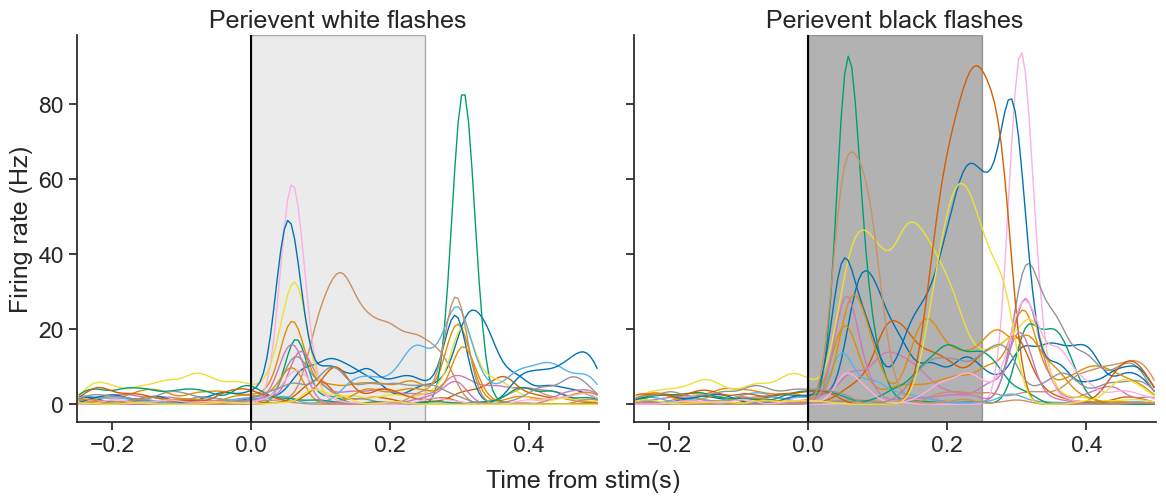

In [787]:
# Get the perievent for a subset of the units (most responsive ones)
peri_white = {k: peri_white[k] for k in units.index if k in peri_white}
peri_black = {k: peri_black[k] for k in units.index if k in peri_black}

params_obs = [peri_white, 
              peri_black]

plot_peri_side_by_side(
    params_obs,
    bin_size
)

or in a raster plot!

In [788]:
def raster_plot(units, n_neurons=len(units), n_flashes=5, n_seconds=13, offset=0.5):
    """
    Plot a raster of spiking activity for a subset of neurons during the initial stimulus presentations.

    This function visualizes spike times as a raster plot for a selected number of neurons
    over a specified time window. The spikes are aligned with stimulus presentations, and 
    flashes of different types (white or black) are shown as shaded regions in the background.

    Parameters
    ----------
    units : nap.TsdFrame
        A `TsdFrame` object where each column corresponds to the spike train of a neuron.
    n_neurons : int, optional
        Number of neurons to include in the plot. Defaults to the total number of units.
    n_flashes : int, optional
        Number of white and black flash presentations to show. Defaults to 5.
    n_seconds : float, optional
        Total duration (in seconds) of the time window to display. Defaults to 13 seconds.
    offset : float, optional
        Time (in seconds) to start plotting before the first flash. Useful to visualize pre-stimulus activity.
        Defaults to 0.5 seconds.

    Returns
    -------
    None
        Displays a raster plot using `matplotlib`.

    Notes
    -----
    - The flashes are overlaid using `axvspan`, with white flashes in light gray and black flashes in black.
    - Each spike is drawn as a vertical line ('|') at its timestamp.
    - Spike times are converted to a single `Tsd` object with unique identifiers for each unit to facilitate plotting.
    """
    start = data["flashes_presentations"]["start"].min() - offset
    end = start + n_seconds

    # Restrict the spike trains to the selected time window
    units = units.restrict(nap.IntervalSet(start, end))

    # Convert spike trains to a single Tsd object and label each neuron for plotting
    neurons_to_plot = units.to_tsd([i + 1 for i in range(n_neurons)])

    fig, ax = plt.subplots(figsize=(17, 4))
    ax.plot(neurons_to_plot, "|", markersize=2, mew=2)

    # Overlay white flashes
    for s, e in zip(flashes_white[:n_flashes].start, flashes_white[:n_flashes].end):
        ax.axvspan(s, e, color="silver", alpha=0.4, ec="black")

    # Overlay black flashes
    for s, e in zip(flashes_black[:n_flashes].start, flashes_black[:n_flashes].end):
        ax.axvspan(s, e, color="black", alpha=0.4, ec="black")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Unit")
    ax.set_title("Primary Visual Cortex (VISp) units spikes and stimuli")
    ax.set_xlim(start, end)

    plt.show()


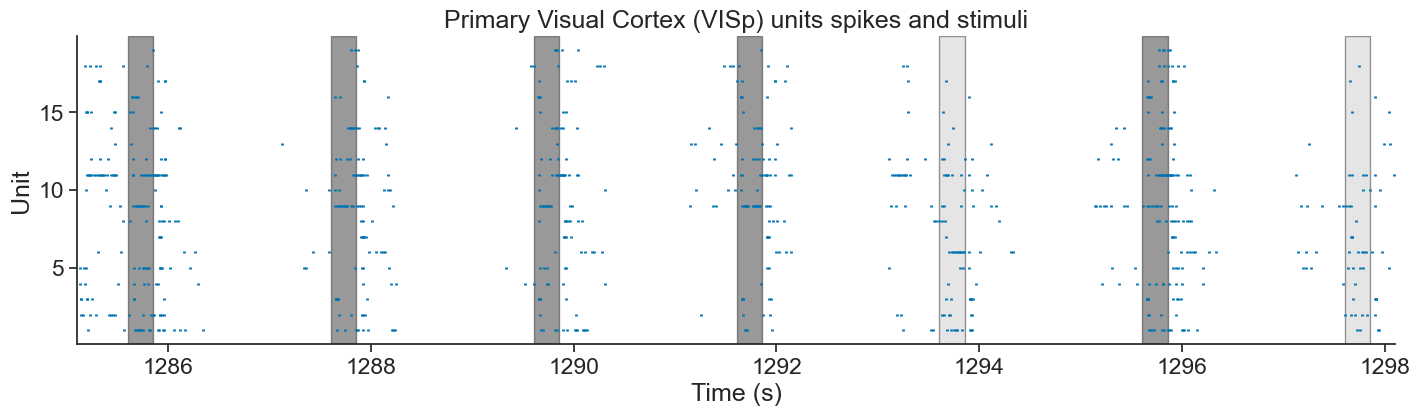

In [789]:
raster_plot(units)

### Splitting the dataset in train and test
We could train the model on the entire dataset. However, if we do so, we wouldn’t have a way to assess whether the model is truly capable of making accurate predictions or if it’s simply overfitting to the data. The simplest way around this is to have a reserved part of the data for testing.

Here, we will split the data in two: 70% will be for training and 30% will be for testing. However, we can't simply grab the first 70% timeseries - what if we are biasing our sample and there are some neurons that respond only towards the end or the beginning of the recording? For that, we will gather one every three flashes, and those will go to the testing set. The rest, will go to the training set.

:::{admonition} How to decide how to split my data?
:class: info
:class: dropdown

The optimal way to split your data depends on your specific research question, the structure of your data, and the modeling goals. There’s no single correct approach—splitting strategies can and should be adapted to the context.

For example, you might choose a simple two-way split (training and test), or include a third validation set to tune model parameters before final testing. Some researchers split their data 50/50, while others use more unbalanced ratios depending on dataset size.

In some cases, it may make sense to split based on stimulus properties or experimental design. Suppose you suspect that a mouse's response to white flashes changes with repeated exposure—e.g., due to habituation. Then, randomly mixing all trials might obscure important patterns. Instead, separating interleaved vs. repeated flash conditions could give you a more meaningful evaluation of model generalization.
:::

In [790]:
# We take one every three flashes (33% of all flashes of test)
flashes_test_white = extended_flashes_white[::3]
flashes_test_black = extended_flashes_black[::3]

**Pynapple** has a nice function to get all the epochs: [```set_diff```](https://pynapple.org/generated/pynapple.IntervalSet.set_diff.html). With it, we can get all of the interval sets which are not in the interval set passed as argument.

In [791]:
# The remaining is separated for training
flashes_train_white = extended_flashes_white.set_diff(flashes_test_white)
flashes_train_black = extended_flashes_black.set_diff(flashes_test_black)

Consider black and white for test and train
using [```union```](https://pynapple.org/generated/pynapple.IntervalSet.union.html#pynapple.IntervalSet.union)

In [792]:
# Merge both stimuli types in a single interval set
flashes_test = flashes_test_white.union(flashes_test_black)
flashes_train = flashes_train_white.union(flashes_train_black)

Now that we have our intervals correctly, we can use [```restrict```](https://pynapple.org/generated/pynapple.TsGroup.restrict.html#pynapple.TsGroup.restrict) to get our test and train sets for units

In [793]:
# General spike counts
units_counts = units.count(bin_size, ep = extended_flashes)

# Restrict counts to test and train
units_counts_test = units_counts.restrict(flashes_test)
units_counts_train = units_counts.restrict(flashes_train)

## Fitting a GLM

### Preparing the data for **NeMos**
Now that we have a good understanding of our data, and that we have splitted our dataset in the corresponding test and train subsets, we are almost ready to run our model. However, before we can construct it, we need to get our data in the right format.

When fitting a single neuron, **NeMoS** requires that the predictors and spike counts it operates on have the following properties:

- predictors and spike counts must have the same number of time points.
- predictors must be two-dimensional, with shape ```(n_time_bins, n_features)```. So far, we have two features in this tutorial: white and black flashes.
- spike counts must be one-dimensional, with shape ```(n_time_bins,)```. 
- predictors and spike counts must be jax.numpy arrays, numpy arrays, [```Tsd```](https://pynapple.org/generated/pynapple.Tsd.html#pynapple.Tsd) or [```TsdFrame```](https://pynapple.org/generated/pynapple.TsdFrame.html#pynapple.TsdFrame).

When fitting multiple neurons, spike counts must be two-dimensional: ```(n_time_bins, n_neurons)```. In that case, spike can be [```TsGroup```](https://pynapple.org/generated/pynapple.TsGroup.html#pynapple.TsGroup) objects as well.

First, we require that our predictors and our spike counts have the same number of time bins.

In [794]:
# Create a TsdFrame filled by zeros, for the size of units_counts
predictors = nap.TsdFrame(
    t=units_counts.t,
    d=np.zeros((len(units_counts), 2)), 
    columns = ['white', 'black']
)

At the moment, the flashes are in a IntervalSet, we need to grab them and make them time series of stimuli, separated by black and white (because we are interested in how neurons' responses are modulated by each individual stimulus type separately).

In [795]:
# Check whether there is a flash within a given bin of spikes
# If there is not, put a nan in that index
idx_white = flashes_white.in_interval(units_counts)
idx_black = flashes_black.in_interval(units_counts)

# Replace everything that is not nan with 1 in the corresponding column
predictors.d[~np.isnan(idx_white), 0] = 1
predictors.d[~np.isnan(idx_black), 1] = 1

print(predictors)

Time (s)        white    black
--------------  -------  -------
1285.103369922  0.0      0.0
1285.108369922  0.0      0.0
1285.113369922  0.0      0.0
1285.118369922  0.0      0.0
1285.123369922  0.0      0.0
1285.128369922  0.0      0.0
1285.133369922  0.0      0.0
...             ...      ...
1584.567539922  0.0      0.0
1584.572539922  0.0      0.0
1584.577539922  0.0      0.0
1584.582539922  0.0      0.0
1584.587539922  0.0      0.0
1584.592539922  0.0      0.0
1584.597539922  0.0      0.0
dtype: float64, shape: (37500, 2)


```predictors``` and ```units_counts``` match in the first dimension because they have the same number of timepoints, as intended. Meanwhile, in the second dimension, predictors is 2 because we have black and white flashes, and counts has 19 because the selected units for this tutorial sums to 19.

In [796]:
print(f"predictors shape: {predictors.shape}")
print(f"\ncount shape: {units_counts.shape}")

predictors shape: (37500, 2)

count shape: (37500, 19)


Just to make sure that we got the right output, let's plot our new ```predictors``` [```TsdFrame```](https://pynapple.org/generated/pynapple.TsdFrame.html#pynapple.TsdFrame) as lines alongside our first plot.

In [ ]:
def stimuli_plot(predictors, n_flashes = 5, n_seconds = 13, offset = .5):
    n_flashes = 5
    n_seconds = 13
    offset = .5

    # Start a little bit earlier than the first flash presentation
    start = data["flashes_presentations"]["start"].min() - offset 
    end = start + n_seconds

    fig, ax = plt.subplots(figsize = (17, 4))

    # Different coloured flashes
    [ax.axvspan(s, e, color = "silver", alpha=.4, ec="black") for s, e in zip(flashes_white[:n_flashes].start, flashes_white[:n_flashes].end)]
    [ax.axvspan(s, e, color = "black", alpha=.4, ec="black") for s, e in zip(flashes_black[:n_flashes].start, flashes_black[:n_flashes].end)]
    plt.plot(predictors["white"], "o-", color= "silver")
    plt.plot(predictors["black"], "o-", color= "black")
    
    plt.xlabel("Time (s)")
    plt.ylabel("Absent = 0, Present = 1")
    ax.set_title("Presented Stimuli")
    
    plt.xlim(start,end) 

    # Only use integer values for ticks
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()


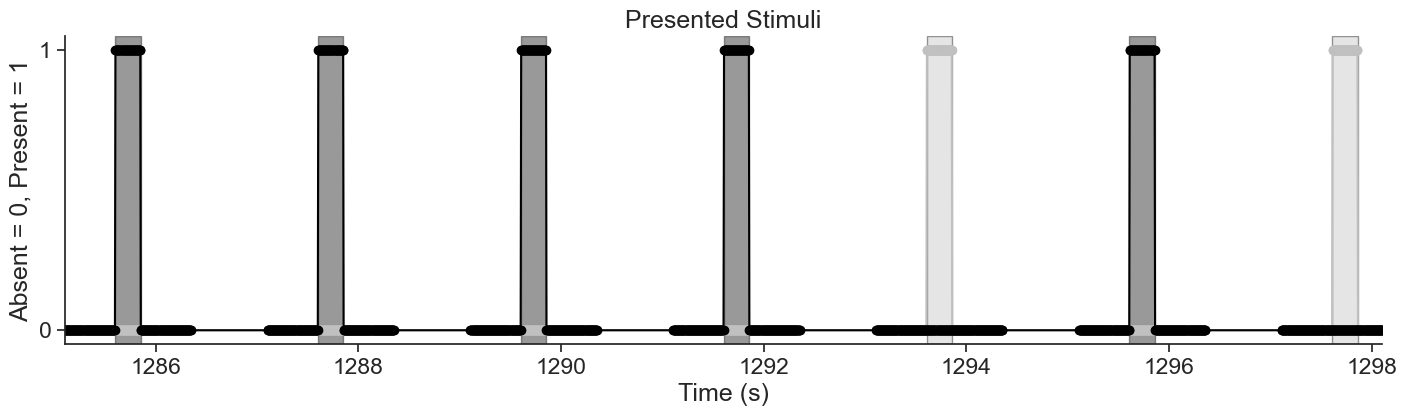

In [798]:
stimuli_plot(predictors)

They match perfectly! 

As a last preprocessing step, let's just split ```predictors``` in train and test.

In [799]:
predictors_test = predictors.restrict(flashes_test)
predictors_train = predictors.restrict(flashes_train)

### Constructing the design matrix using basis functions

Right now, our predictors are composed by black and white flashes at every time point, but that would imply assuming that the neuron's spiking behavior is only driven by the instantaneous flash presentation. However, we know neurons integrate information over time, so why not changing our predictors to reflect that? 

We can achieve this by including variables that represent the history of exposure to the flashes. For this, we must decide the duration of time that we think is relevant: does the exposure to flashes 10ms ago matter? What about 100ms ago? 1s? We should use priori knowledge of our system to determine a initial value. 

For this tutorial, we will use the whole duration of the stimuli as relevant history. That is, we will model each unit’s response to 250 ms full-field flashes by capturing how stimulus history over that duration influences spiking. We therefore define a 250 ms stimulus window, aligned with the flash onset, which spans the entire stimulus duration. This window enables the GLM to learn how the neuron's firing rate evolves throughout the flash. Using a shorter window could omit delayed effects, while a longer window may incorporate unrelated post-stimulus activity.

To construct our stimulus history predictor, we could generate time-lagged copies of the stimulus input (in the form of a [Hankel Matrix](https://en.wikipedia.org/wiki/Hankel_matrix)). Specifically, the value of the first predictor at time $ t $ would correspond to the stimulus at time $ t $, while the second predictor would capture the stimulus at time $ t - 1 $ , and so on, up to a maximum lag corresponding to the length of the stimulus integration window (250 ms in our case).

:::{admonition} How do you build a Hankel matrix?
:class: info

Every row is a shifted copy of the row above!

![hankel_matrix](../../data/images/hankel_matrix.gif)

Construction of Hankel Matrix. Modified from {cite:t}`PillowCosyneTutorial` <span id="cite3"></span><a href="#ref3">[3]</a>.
:::

However, modeling each time lag with an independent parameter leads to a high-dimensional filter that is prone to overfitting! (Given that we are using a bin size of 0.005, we would end up with 50 lags = 50 parameters per flash color!) A better idea is to do some dimensionality reduction on these predictors, by parametrizing them using basis functions. This will allow us to capture interesting non-linear effects with a relatively low-dimensional parametrization that preserves convexity. 

**NeMoS** has a whole library of basis objects available at [```nmo.basis```](https://nemos.readthedocs.io/en/latest/background/basis/README.html#table-basis). Choosing which set of basis functions to use, as well as setting their parameters (like choosing the duration of the flash history predictor) requires knowledge of your problem, but can later be examined using model comparison tools.

For history-type inputs like we’re discussing, the raised cosine log-stretched basis first described in {cite:t}`pillowPredictionDecodingRetinal2005`<span id="cite4"></span><a href="#ref4"> [4]</a> is a good fit. This basis set has the nice property that their precision drops linearly with distance from event, which is a makes sense for many history-related inputs in neuroscience: whether an input happened 1 or 5 ms ago matters a lot, whereas whether an input happened 51 or 55 ms ago is less important.

  

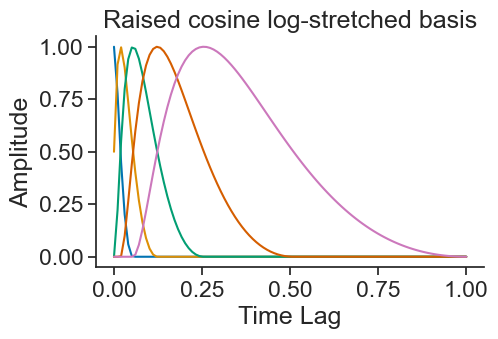

In [800]:
# Duration of stimuli
stimulus_history_duration = 0.25 

# Window length in bin size units
window_len = int(stimulus_history_duration / bin_size)

basis_example = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs = 5, 
    window_size = window_len, 
)
sample_points, basis_values = basis_example.evaluate_on_grid(100)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(sample_points, basis_values)
ax.set_title("Raised cosine log-stretched basis")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time Lag")
plt.show()

When we instantiate this object, the only arguments we need to specify is the number of functions we want and the mode of operation of the basis:
- Number of functions: with more basis functions, we’ll be able to represent the effect of the corresponding input with the higher precision, at the cost of adding additional parameters.
- Mode of operation: either ```Conv``` for convolutional or ```Eval```for evaluation form of the basis. This is determined by the type of feature we aim to represent. This is not a parameter; instead, the choice of basis will include ```Conv``` or ```Eval``` in the name.

:::{admonition} When should I use the convolutional or evaluation form of the basis?
:class: info
- Evaluation bases transform the input through the non-linear function defined by the basis. This can be used to represent features such as spatial location and head direction.
- Convolution bases apply a convolution of the input data to the bank of filters defined by the basis, and is particularly useful when analyzing data with inherent temporal dependencies, such as spike history or the history of flash exposure in this example. In convolution mode, we must additionally specify the ```window_size``` (the length of the filters in bins).
:::

In [801]:
# Duration of stimuli
stimulus_history_duration = 0.250

# Window length in bin size units
window_len = int(stimulus_history_duration / bin_size)

# Initialize basis objects
# White basis
basis_white = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs = 5, 
    window_size = window_len, 
    label = "white"
)
# Black basis
basis_black = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs = 5, 
    window_size = window_len, 
    label = "black"
)

Using the [```compute_features```](https://nemos.readthedocs.io/en/latest/generated/_basis/nemos.basis._basis.AdditiveBasis.compute_features.html#nemos.basis._basis.AdditiveBasis.compute_features) function, **NeMos** convolves our input features (predictors) with the basis object to compress them. How does that look like?

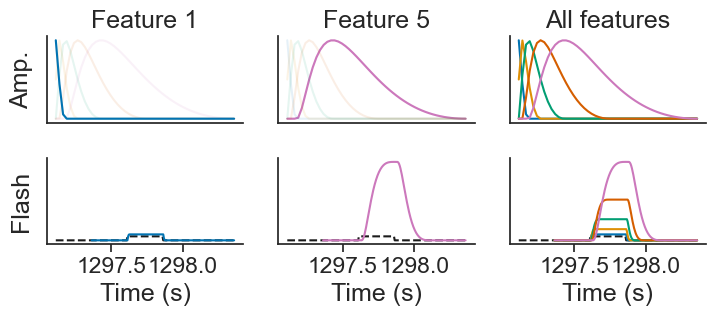

In [802]:
# Use only first flash presentation for plot
interval= flashes_train_white[0]

# Compute features
features = basis_white.compute_features(predictors_train["white"])

# Initialize plot
fig, axes = plt.subplots(2, 3, sharey="row", figsize=(7.5, 3.5), tight_layout=True)

# Create time axis
time, basis = basis_white.evaluate_on_grid(basis_white.window_size)
time *= window_len

# Restrict predictors and features to first flash presentation
flashes = predictors_train["white"].restrict(interval)
features = features.restrict(interval) 

# Plot raw predictors
for ax in axes[1, :]:
    ax.plot(flashes, "k--", label="true")
    ax.set_xlabel("Time (s)")

# Plot first basis function
axes[0, 0].plot(time, basis, alpha=0.1)
axes[0, 0].set_xticks([])
axes[0, 0].plot(time, basis[:, 0], "C0", alpha=1)
axes[0, 0].set_ylabel("Amp.")
axes[0, 0].set_yticks([])

# Plot first Feature (first basis function convolved with input)
axes[0, 0].set_title("Feature 1")
axes[1, 0].plot(features[:, 0], label="conv.")
axes[1, 0].set_ylabel("Flash")
axes[1, 0].set_yticks([])

# Plot last basis function
axes[0, 1].plot(time, basis[:, -1], f"C{basis.shape[1]-1}", alpha=1)
axes[0, 1].set_xticks([])
axes[0, 1].set_title(f"Feature {basis.shape[1]}")

# Plot last feature
axes[1, 1].plot(features[:, -1], f"C{basis.shape[1]-1}")
axes[0, 1].plot(time, basis, alpha=0.1)

# Plot all basis functions
axes[0, 2].plot(time, basis)
axes[0, 2].set_xticks([])
axes[0, 2].set_title("All features")

# Plot all features
axes[1, 2].plot(features)

plt.show()

On the top row, we can see the basis function, same as in the plot above. On the bottom row, we are showing one flash presentation, as a dashed line, and corresponding features over a small window of time. These features are the result of a convolution between the basis function on the top row with the black dashed line showed below. The basis functions get progressively wider and delayed from the flash onset, so we can think of the features as weighted averages that get progressively later and smoother.

In the leftmost plot, we can see that the first feature almost perfectly tracks the input. Looking at the basis function above, that makes sense: this function’s max is at 0 and quickly decays. In the middle plot, we can see that the last feature has a fairly long lag compared to the flash, and is a lot smoother. Looking at the rightmost plot, we can see that the other features vary between these two extremes, getting smoother and more delayed.

These are the elements of our feature matrix: representations of not just the instantaneous presentation of a flash, but also the its history. Let’s see what this looks like when we go to fit the model!

In our case, we want our basis to be composed by both black and white flashes features. For that, we can build an [```additive basis```](https://nemos.readthedocs.io/en/latest/generated/_basis/nemos.basis._basis.AdditiveBasis.html), simply by adding our already declared basis objects.

In [803]:
# Define additive basis object
additive_basis = basis_white + basis_black

# Convolve basis with inputs - train set
X_train = additive_basis.compute_features(
    predictors_train["white"], # Corresponding to basis_white
    predictors_train["black"]  # Corresponding to basis_black
)

# Convolve basis with inputs - test set
X_test = additive_basis.compute_features(
    predictors_test["white"], 
    predictors_test["black"]
)

:::{admonition} More resources on basis functions
:class: info
:class: dropdown
- [**NeMos** fit head-direction population tutorial](https://nemos.readthedocs.io/en/latest/tutorials/plot_02_head_direction.html): For a step by step explanation of how to build the design matrix first as a result of convolving the features with the identity matrix, and then by using basis functions, alongside nice visualizations.
- [Flatiron Institute Introduction to GLMs tutorial](https://flatironinstitute.github.io/neurorse-workshops/workshops/jan-2025/branch/main/full/day2/current_injection.html#fitting-the-model): For a detailed explanation, step by step, on how predictors look with and without basis functions, with nice visualizations as well.
- [**NeMos** notebook on composition of basis functions](https://nemos.readthedocs.io/en/latest/background/basis/plot_02_ND_basis_function.html): For a detailed explanation of the different operations that can be carried out using basis functions in 2 and more dimensions.
- [Bishop, 2009](https://www.microsoft.com/en-us/research/wp-content/uploads/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf): Section 3.1 for a formal description of what basis functions are and some examples of them.
:::

### Initialize and fit a GLM: single unit

Now we are finally ready to start our model!

First, we need to define our GLM model object. To initialize our model, we need to specify the ```solver_name```, the ```regularizer```, the ```regularizer_strength``` and the ```observation_model```. All of these are optional.

- ```solver_name```: this string specifies the solver algorithm. The default behavior depends on the regularizer, as each regularization scheme is only compatible with a subset of possible solvers.
- ```regularizer```: this string or object specifies the regularization scheme. Regularization modifies the objective function to reflect your prior beliefs about the parameters, such as sparsity. Regularization becomes more important as the number of input features, and thus model parameters, grows. **NeMos**’s solvers can be found within the [```nemos.regularizer```](https://nemos.readthedocs.io/en/latest/generated/regularizer/nemos.regularizer.Regularizer.html#nemos.regularizer.Regularizer) module.
- ```observation_model```: this object links the firing rate and the observed data (in this case spikes), describing the distribution of neural activity (and thus changing the log-likelihood). For spiking data, we use the Poisson observation model.

For this tutorial, we’ll use a LBFGS ```solver_name``` with Ridge ```regularizer```, and a ```regularizer_strength``` of 0.0004.

:::{admonition} Why LBFGS?
:class: info
:class: dropdown

LBFGS is a quasi-Netwon method, that is, it uses the first derivative (the gradient) and approximates the second derivative (the Hessian) in order to solve the problem. This means that LBFGS tends to find a solution faster and is often less sensitive to step-size. Try other solvers to see how they behave!
:::

:::{admonition} What is regularization?
:class: info
:class: dropdown

When fitting models, it is generally recommended to use regularization, a technique that adds a constraint or penalty to the model’s cost function. Regularization works by discouraging the coefficients from reaching large values.

Penalizing large coefficients is beneficial because it helps prevent overfitting, a phenomenon in which the model fits the training data too closely, capturing noise instead of the underlying pattern. Large coefficients often indicate a model that is too complex or sensitive to small fluctuations in the data. By keeping coefficients smaller and more stable, regularization promotes simpler models that generalize better to unseen data, improving predictive performance and robustness.

In this tutorial, we will use Ridge regularization (or L2 regularization). In this type of regularization, the penalty term added to the loss function is:

$$
\text{Penalty} = \frac{\lambda}{2N} \sum_{j} \theta_j^2
$$

where $\lambda$ is the regularization strength, $N$ is the number of samples and $\theta_j$ are the model coefficients, stored in [```model.coef_```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.html#nemos.glm.GLM.coef_).

Please refer to [**NeMos** documentation](https://nemos.readthedocs.io/en/latest/generated/regularizer/nemos.regularizer.Ridge.html#nemos.regularizer.Ridge) for more details on how this was implemented.

:::

In [804]:
regularizer_strength = 0.0004
# Initialize model object of a single unit
model = nmo.glm.GLM(
    regularizer = "Ridge",
    regularizer_strength = regularizer_strength,
    solver_name="LBFGS", 
)

:::{admonition} Where did the ```regularizer_strength``` value come from?
:class: info
:class: dropdown

We conducted cross validation to obtain the regularization strength:

```
from sklearn.model_selection import GridSearchCV

# Initialize model object
model = nmo.glm.GLM(
    regularizer = "Ridge",
    regularizer_strength = 0.01,
    solver_name="LBFGS", 
    #solver_kwargs=dict(tol=10**-12)
)

# Create parameter grid
param_grid = {
    "regularizer_strength" : 
    np.geomspace(10**-9, 10, 10)
}

# Instantiate the grid search object
grid_search = GridSearchCV(
    model,param_grid, 
    cv=5
    )

# Run grid search
grid_search.fit(X_train, u_counts_train)

# Print optimal parameter
print(grid_search.best_estimator_.regularizer_strength)
>>> 0.00035938136638046257
```

In this tutorial, for conciseness, we will use the regularizer strength obtained for this single neuron across the entire population. However, please note that when running your own analysis, it is necessary to find the optimal regularizer strength for each neuron individually, as there is no guarantee that the optimal solution for one neuron will also be optimal for another.
::: 

First let's choose an example unit to fit.

In [805]:
# Choose an example unit
unit_id = 951768291

# Get counts for train and test for said unit
u_counts_train = units_counts_train.loc[unit_id]
u_counts_test = units_counts_test.loc[unit_id]

**NeMos** models are intended to be used like [**scikit-learn**](https://scikit-learn.org/stable/getting_started.html) estimators. In these, a model instance is initialized with hyperparameters (like regularization strength, solver, etc), and then we can call the [```fit()```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.fit.html#nemos.glm.GLM.fit) function to fit the model to data. Since we have already created our model and have our data, we can go ahead and call [```fit()```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.fit.html#nemos.glm.GLM.fit).

In [806]:
model.fit(X_train, u_counts_train)

GLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.0004,
    solver_name='LBFGS'
)

Now that we have fit our data, we can retrieve the resulting parameters. Similar to scikit-learn, these are stored as the [```coef_```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.html#nemos.glm.GLM.coef_).and [```intercept_```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.html#nemos.glm.GLM.intercept_) attributes:

In [807]:
print(f"firing_rate(t) = exp({model.coef_} * flash(t) + {model.intercept_})")

firing_rate(t) = exp([-0.22001135 -0.35356084  0.23402299  1.6522639  -1.1317117  -0.32143256
 -0.6298954  -1.6505908  -0.53825456  0.5773484 ] * flash(t) + [-7.7220736])


:::{admonition} Note
:class: info
Note that [```model.coef_```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.html#nemos.glm.GLM.coef_) has shape ```(n_features, )```, while [```model.intercept_```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.html#nemos.glm.GLM.intercept_) has shape (```n_neurons```):

```
print(model.coef_.shape)
>>> (10,)

print(model.intercept_.shape)
>>> (1,)
```
:::

### Assess GLM performance: predict

Although it is helpful to examine the model parameters, they don't tell us much about how well the model is performing. So how can we assess its quality?

One way is to use the model to predict firing rates and compare those predictions to the smoothed spike train. By calling [```predict```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.predict.html#nemos.glm.GLM.predict), we obtain the model’s predicted firing rate for the input data — that is, the output of the nonlinearity.

In [808]:
# Use predict to obtain the firing rates
pred_unit = model.predict(X_test)

# Convert units from spikes/bin to spikes/sec
pred_unit = pred_unit/ bin_size

print(pred_unit)

Time (s)
--------------  -----------
1285.103369922  nan
1285.108369922  nan
1285.113369922  nan
1285.118369922  nan
1285.123369922  nan
1285.128369922  nan
1285.133369922  nan
...
1576.560859922    0.0885882
1576.565859922    0.0885882
1576.570859922    0.0885882
1576.575859922    0.0885882
1576.580859922    0.0885882
1576.585859922    0.0885882
1576.590859922    0.0885882
dtype: float32, shape: (12500,)


:::{admonition} Why do we have so many nan values at the beginning of the time-series?
:class: info
:class: dropdown

This is due to the convolution window used when applying the basis functions. In our case, the model uses a 250 ms temporal window, meaning that at any given time point, the model looks back 250 ms into the stimulus history.

However, we’ve restricted our input stimuli to the window from 500 ms before to 500 ms after each flash onset. As a result, during the first 250 ms of each trial, the convolution cannot be fully computed — the model lacks sufficient preceding data to construct the input to the linear filter. This leads to NaN values in the predicted firing rate during this initial period.

Given our bin size of 5 ms, 250 ms corresponds to 50 time bins. Thus, we expect the first 50 time points of the prediction to contain NaNs. After that, the model has enough history to compute valid predictions.

For example, if we inspect the predictions starting at timepoint 50, we no longer see NaN values:
```
print(pred_unit[50:])
>>> Time (s)
--------------  ---------
1285.353369922  0.0885882
1285.358369922  0.0885882
1285.363369922  0.0885882
1285.368369922  0.0885882
1285.373369922  0.0885882
1285.378369922  0.0885882
1285.383369922  0.0885882
...
1576.560859922  0.0885882
1576.565859922  0.0885882
1576.570859922  0.0885882
1576.575859922  0.0885882
1576.580859922  0.0885882
1576.585859922  0.0885882
1576.590859922  0.0885882
dtype: float32, shape: (12450,)
```
By contrast, timepoint 49 still includes a NaN:

```
print(pred_unit[49:])
>>> Time (s)
--------------  -----------
1285.348369922  nan
1285.353369922    0.0885882
1285.358369922    0.0885882
1285.363369922    0.0885882
1285.368369922    0.0885882
1285.373369922    0.0885882
1285.378369922    0.0885882
...
1576.560859922    0.0885882
1576.565859922    0.0885882
1576.570859922    0.0885882
1576.575859922    0.0885882
1576.580859922    0.0885882
1576.585859922    0.0885882
1576.590859922    0.0885882
dtype: float32, shape: (12451,)
```
So, the NaNs are not an error — they’re simply a byproduct of the convolution requiring a full 250 ms history before producing an output.

:::

Now, we can use **Pynapple** function [```compute_perievent_continuous```](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent_continuous) to re-center the timestamps of the predicted rates around the stimulus presentations, in a similar manner than at the beginning of the tutorial. In contrast to [```compute_perievent```](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent), [```compute_perievent_continuous```](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent_continuous) allows us to center a continuous time series.

We re-center the timestamps in the same way as we did at the beginning of the tutorial.

In [809]:
# Calculate perievent for white stimuli
# +50 because we added +.50 at beginning and end of stimulus
peri_white_pred_unit = nap.compute_perievent_continuous(
    timeseries = pred_unit, 
    tref = nap.Ts(flashes_test_white.start+.50),
    minmax=window_size
)  
# Calculate perievent for black stimuli
# +50 because we added +.50 at beginning and end of stimulus
peri_black_pred_unit = nap.compute_perievent_continuous(
    timeseries = pred_unit, 
    tref = nap.Ts(flashes_test_black.start+.50), 
    minmax=window_size
)  

# Print centered spikes
print(peri_white_pred_unit)

Time (s)    0        1        2        3        4        ...
----------  -------  -------  -------  -------  -------  -----
-0.25       nan      nan      0.08859  nan      nan      ...
-0.245      0.08859  0.08859  0.08859  0.08859  0.08859  ...
-0.24       0.08859  0.08859  0.08859  0.08859  0.08859  ...
-0.235      0.08859  0.08859  0.08859  0.08859  0.08859  ...
-0.23       0.08859  0.08859  0.08859  0.08859  0.08859  ...
-0.225      0.08859  0.08859  0.08859  0.08859  0.08859  ...
-0.22       0.08859  0.08859  0.08859  0.08859  0.08859  ...
...         ...      ...      ...      ...      ...      ...
0.47        0.083    0.083    0.08521  0.083    0.083    ...
0.475       0.08521  0.08521  0.08676  0.08521  0.08521  ...
0.48        0.08676  0.08676  0.08774  0.08676  0.08676  ...
0.485       0.08774  0.08774  0.08829  0.08774  0.08774  ...
0.49        0.08829  0.08829  0.08853  0.08829  0.08829  ...
0.495       0.08853  0.08853  0.08859  0.08853  0.08853  ...
0.5         0.08859  0

The resulting object is a **Pynapple** [```TsdFrame```](https://pynapple.org/generated/pynapple.TsdFrame.html#pynapple.TsdFrame) of shape ```(n_time_bins,n_trials)``` (we are defining one trial as one presentation of stimuli).

With that, we can plot the PETH of both the average firing rate of this unit and the average predicted rate.

In [810]:
def plot_peri_predict(
        peri_white_pred_unit, 
        peri_black_pred_unit, 
        peri_white, 
        peri_black,
        unit_id = unit_id
    
):
    fig, ax = plt.subplots(1,2,figsize=(17, 4), sharey=True)
    ### white
    # predicted
    ax[0].plot(np.mean(peri_white_pred_unit,axis=1), linewidth=1.5, color="red", label = "predicted")

    peri_u = peri_white[unit_id]
    peri_u_count = peri_u.count(bin_size)

    peri_u_count_conv_mean = np.mean(peri_u_count, 1).smooth(std=0.015)
    peri_u_rate_conv = peri_u_count_conv_mean / bin_size
    # observed
    ax[0].plot(peri_u_rate_conv, linewidth=2, color="black")
    ax[0].axvline(0.0)
    ax[0].axvspan(0, 0.250, color="silver", alpha=0.3, ec="black")
    ax[0].set_xlim(-.25, .5)

    ax[0].set_title("White flashes")

    #### black
    # predicted
    ax[1].plot(np.mean(peri_black_pred_unit,axis=1), linewidth=1.5, color="red")

    peri_u = peri_black[unit_id]
    peri_u_count = peri_u.count(bin_size)

    peri_u_count_conv_mean = np.mean(peri_u_count, 1).smooth(std=0.015)
    peri_u_rate_conv = peri_u_count_conv_mean / bin_size
    # observed
    ax[1].plot(peri_u_rate_conv, linewidth=2, color="black", label = "observed")
    ax[1].axvline(0.0)
    ax[1].axvspan(0, 0.250, color="black", alpha=0.3, ec="black")
    ax[1].set_xlim(-.25, .5)

    ax[1].set_title("Black flashes")
    ax[0].set_ylabel("Rate (Hz)")

    fig.text(0.5, -.05, 'Time from stim(s)', ha='center')
    fig.text(0.5, .95, f'PETH unit {unit_id}', ha='center')
    fig.legend()
    plt.show()


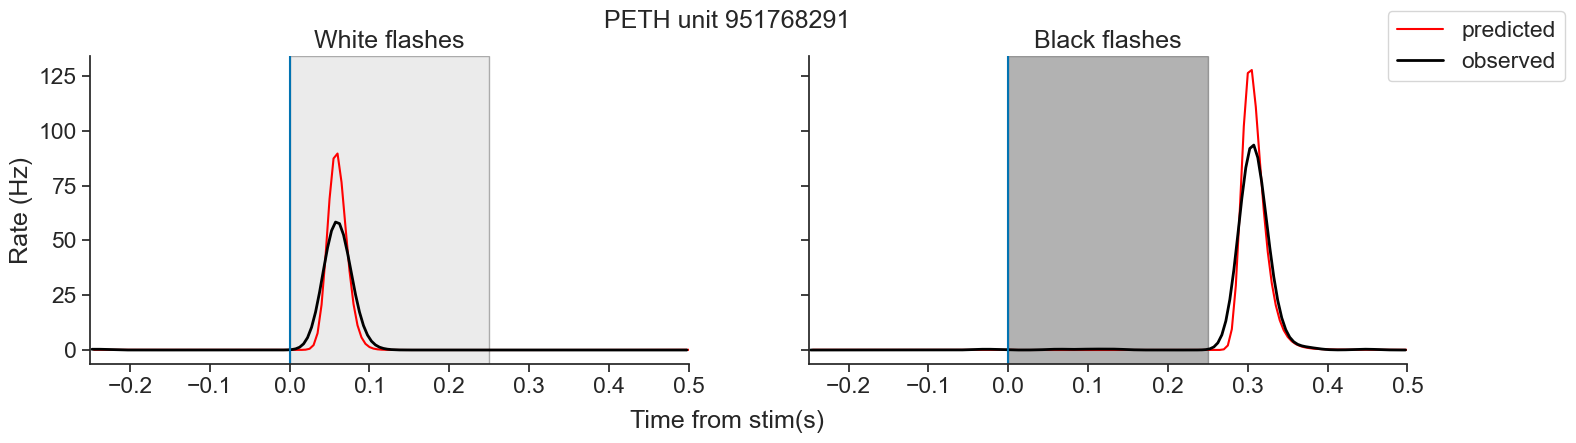

In [811]:
plot_peri_predict(peri_white_pred_unit, 
        peri_black_pred_unit, 
        peri_white, 
        peri_black
)

Now, we can move to fit all neurons!

### Initialize and fit a GLM: [```PopulationGLM```](https://nemos.readthedocs.io/en/latest/how_to_guide/plot_03_population_glm.html)
**NeMos** has a separate [```PopulationGLM```](https://nemos.readthedocs.io/en/latest/how_to_guide/plot_03_population_glm.html) object for fitting a population of neurons. This is equivalent to fitting each individually in a loop, but faster. It operates very similarly to the [```GLM```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.html#nemos.glm.GLM.coef_) object we used a moment ago.

The first step is initializing the model, as with the ```GLM``` object.

In [812]:
model_stimuli = nmo.glm.PopulationGLM(
    regularizer = "Ridge",
    regularizer_strength = regularizer_strength,
    solver_name="LBFGS" 
)

Our input for the [```PopulationGLM```](https://nemos.readthedocs.io/en/latest/how_to_guide/plot_03_population_glm.html) can be the same basis object we used for fitting a single unit. Since we now want to fit all neurons, the counts for our model will be ```units_counts_train```. With that, we call [```model_stimuli.fit()```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.fit.html#nemos.glm.PopulationGLM.fit) to fit our model.

In [813]:
model_stimuli.fit(
    X_train,
    units_counts_train
)

PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.0004,
    solver_name='LBFGS'
)

Same as before, our coefficients live in the [```coef_```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.html#nemos.glm.PopulationGLM.coef_) attribute, while our intercept is stored in the [```intercept_```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.html#nemos.glm.PopulationGLM.intercept_) attribute.

However, since here we have fitted all units, the shape of our [```coef_```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.html#nemos.glm.PopulationGLM.coef_) output will be ```(n_coefficients, n_units)```. Similarly, the shape of our [```intercept_```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.html#nemos.glm.PopulationGLM.intercept_) output will be ```(n_units,)``` because there is one intercept per unit.

In [814]:
print(model_stimuli.coef_.shape)
print(model_stimuli.intercept_.shape)

(10, 19)
(19,)


### Assess [```PopulationGLM```](https://nemos.readthedocs.io/en/latest/how_to_guide/plot_03_population_glm.html) performance: PETH

To evaluate how well our [```PopulationGLM```](https://nemos.readthedocs.io/en/latest/how_to_guide/plot_03_population_glm.html) model captures the neural responses, we can visualize the activity of individual units using a PETH.

For that, we first use the [```predict```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.predict.html#nemos.glm.PopulationGLM.predict) function.

In [815]:
# Predict spikes rate of all neurons in the population
predicted = model_stimuli.predict(X_test)

# Convert units from spikes/bin to spikes/sec
predicted = predicted/ bin_size

Then, we use **Pynapple** function [```compute_perievent_continuous```](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent_continuous) to re-center the timestamps of the observed and predicted rates around the stimulus presentations.

In [816]:
# Calculate perievent for test set
peri_white_test = nap.compute_perievent_continuous(
    timeseries = units.restrict(flashes_test).count(bin_size),
    tref = nap.Ts(flashes_test_white.start+.50),
    minmax = (window_size)
)

# Calculate perievent for test set
peri_black_test = nap.compute_perievent_continuous(
    timeseries =  units.restrict(flashes_test).count(bin_size),
    tref = nap.Ts(flashes_test_black.start+.50),
    minmax = (window_size)
)

# Calculate perievent for predicted
peri_white_pred = nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_white.start+.50),
    minmax=(window_size)
)  

# Calculate perievent for predicted
peri_black_pred =  nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_black.start+.50),
    minmax=(window_size)
)  

We can then plot the centered spikes in a PETH! Let's see how that looks for the first 8 units.

In [817]:
def plot_pop_peth(
        peri_color, 
        color_flashes, 
        bin_size, 
        smoothing=0.015,
        n_units = 8, 
        **peri_others
        ):
    """
    Plot perievent time histograms (PETHs) and raster plots for multiple units.

    Parameters:
    -----------
    peri_color : dict
        Dictionary mapping unit names to binned spike count peri-stimulus data (e.g., binned time series).
    units : dict
        Dictionary of neural units, e.g., spike trains or trial-aligned spike events.
    color_flashes : str
        A label indicating the flash color condition ('black' or other), used for visual styling.
    bin_size : float
        Size of the bin used for spike count computation (in seconds).
    smoothing : float
        Standard deviation for Gaussian smoothing of the PETH traces.
    """

    # Layout setup: 7 columns (units), 2 rows (split vertically into PETH and raster plot)
    n_cols = n_units
    n_rows = 1
    fig, ax = plt.subplots(n_rows, n_cols)
    fig.set_figheight(3)
    fig.set_figwidth(20)
    fig.tight_layout()

    # Use tab20 color palette for plotting different units
    colors = plt.cm.tab20.colors[:n_cols]

    start = 0
    end = n_rows # Plot as many units as half the number of rows 
                            # each unit occupies 2 rows (one for peth and other for raster)

    for i in range(n_units):

        u = peri_color[:,:,i]

        # Plot PETH (smoothed firing rate)
        if (i == 0):
            ax[i].plot(
            (np.mean(u, axis=1) / bin_size).smooth(std=smoothing),
            linewidth=2,
            color="black",
            label = "Observed"
        )
        else:
            ax[i].plot(
                (np.mean(u, axis=1) / bin_size).smooth(std=smoothing),
                linewidth=2,
                color="black",
            )

        ax[i].axvline(0.0)  # Stimulus onset line
        span_color = "black" if color_flashes == "black" else "silver"
        ax[i].axvspan(0, 0.250, color=span_color, alpha=0.3, ec="black")  # Stim duration
        ax[i].set_xlim(-0.25, 0.50)
        ax[i].set_title(f'{i}')
        for (label, color, peri_pred) in peri_others.values():
            u_pred = peri_pred[:,:,i]
            if (i == 0):
                ax[i].plot(
                (np.mean(u_pred, axis=1)),
                linewidth=1.5,
                color=color,
                label = label
            )
            else:
                ax[i].plot(
                (np.mean(u_pred, axis=1)),
                linewidth=1.5,
                color=color,
            )


        # Shift window for next units
        start += 1
        end += 1
    
    # Y-axis and title annotations
    ax[0].set_ylabel("Rate (Hz)")
    if n_rows > 2:
        ax[2, 0].set_ylabel("Rate (Hz)")
        ax[3, 0].set_ylabel("Trial")
    fig.legend()
    fig.text(0.5, 0.00, 'Time from stim(s)', ha='center')
    fig.text(0.5, 1.00, f'PETH - {color_flashes} flashes', ha='center')

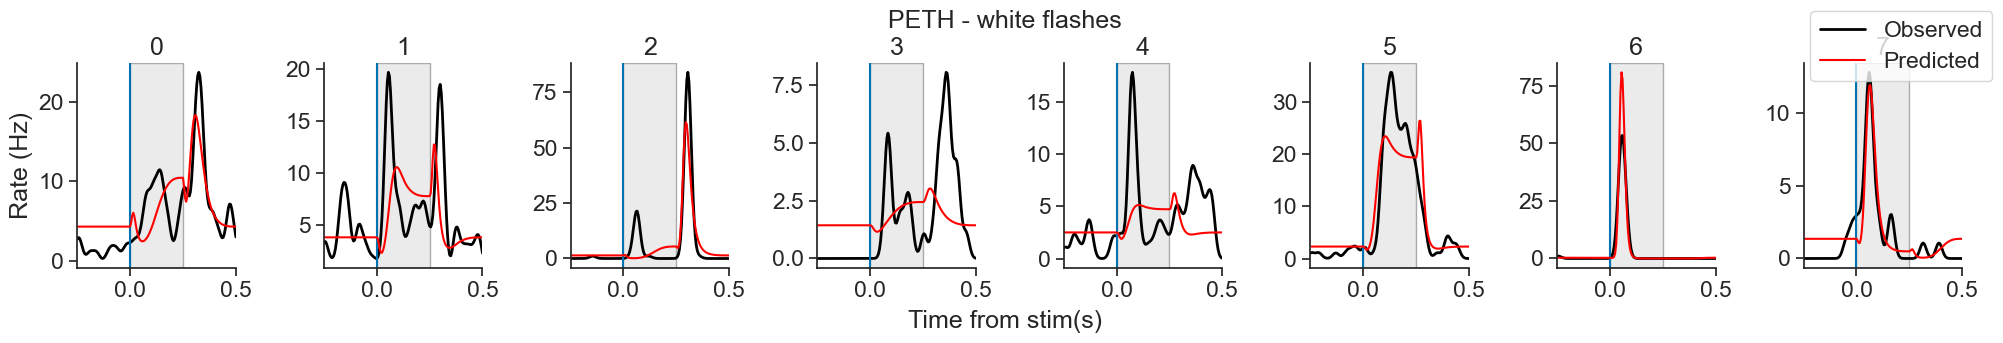

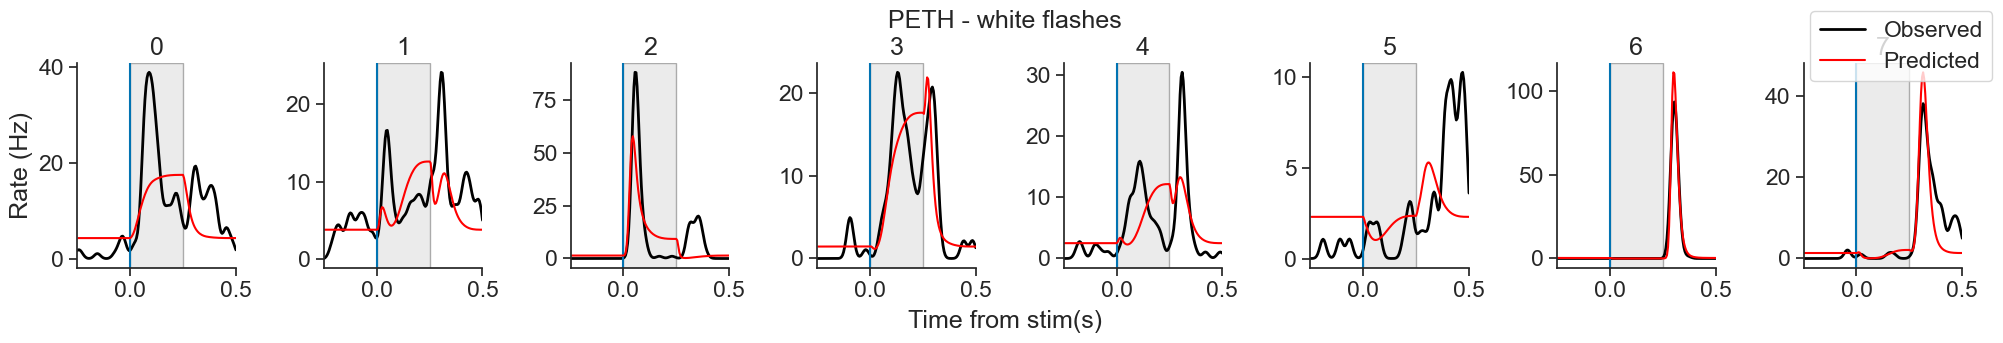

In [818]:
plot_pop_peth(
    peri_white_test, 
    "white", 
    bin_size,
    peri_pred_stimuli = ("Predicted", "red", peri_white_pred)
    )

plot_pop_peth(
    peri_black_test, 
    "white", 
    bin_size,
    peri_pred_stimuli = ("Predicted", "red", peri_black_pred)
    )

In our case, the predicted activity lacks much of the temporal structure seen in the observed data. This suggests that the model, which currently only includes stimulus history (black/white flash for a 250ms duration filter), may be too simple. What could we try to improve this model a little bit? 

## Adding coupling as a new predictor
We can try extending the model in order to improve its performance. There are many ways one can do this: the iterative refinement and improvement of your model is an important part of the scientific process! In this tutorial, we’ll discuss one such extension, but you’re encouraged to try others.

Now, we'll extend the model by adding coupling terms—that is, including the activity of other neurons as predictors—to account for shared variability within the network. It's been shown by  {cite:t}`pillowSpatiotemporalCorrelationsVisual2008` 
   <span id="cite1b"></span><a href="#ref1">[1b]</a> that spike times can be predicted more accurately when taking into acount the spiking of neighbouring units. 

We start by creating a new additive basis, which will now include the spike counts of all the population.

In [819]:
# New basis object for coupling
basis_coupling = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=8, window_size=window_len, label="spike_history"
)

# New additive basis with coupling term
basis = basis_white + basis_black + basis_coupling

# Compute the features for train and test
# Separate basis objects
X_coupling_train = basis.compute_features(
    predictors_train["white"], 
    predictors_train["black"], 
    units_counts_train
)
X_coupling_test = basis.compute_features(
    predictors_test["white"], 
    predictors_test["black"], 
    units_counts_test
)

We initialize a new [```PopulationGLM```](https://nemos.readthedocs.io/en/latest/how_to_guide/plot_03_population_glm.html) object

In [820]:
regularizer_strength = 0.005 

model_coupling = nmo.glm.PopulationGLM(
    regularizer = "Ridge",
    regularizer_strength = regularizer_strength,
    solver_name="LBFGS"
)

:::{admonition} Where did this new ```regularizer_strength``` value come from?
:class: info
:class: dropdown

We conducted cross validation again to obtain the regularization strength for this new model. Adding extra parameters increases the risk of overfitting, so getting a new ```regularizer_strength``` to account for that makes sense.

```
from sklearn.model_selection import GridSearchCV

model_coupling = nmo.glm.PopulationGLM(
    regularizer = "Ridge",
    regularizer_strength = regularizer_strength,
    solver_name="LBFGS"
)
# Create parameter grid
param_grid = {
    "regularizer_strength" : 
    np.geomspace(10**-9, 10, 10)
}

# Instantiate the grid search object
grid_search = GridSearchCV(
    model_coupling,param_grid, 
    cv=5
    )

# Run grid search
grid_search.fit(X_coupling_train, units_counts_train)

# Print optimal parameter
print(grid_search.best_estimator_.regularizer_strength)
>>> 0.004641588833612782
```

Here we got a regularizer strength for the whole population but, again, when conducting a real analysis, a regularizer strength must be obtained for each unit.
::: 

And we fit calling [```model_coupling.fit()```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.fit.html#nemos.glm.PopulationGLM.fit)

In [821]:
model_coupling.fit(X_coupling_train,units_counts_train)

PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.005,
    solver_name='LBFGS'
)

### Assess coupling [```PopulationGLM```](https://nemos.readthedocs.io/en/latest/how_to_guide/plot_03_population_glm.html) performance: heatmap

Another way to visually inspect how well our [```PopulationGLM```](https://nemos.readthedocs.io/en/latest/how_to_guide/plot_03_population_glm.html) model captures the neural responses is to summarize the activity from all the units using a heatmap. Here's how we construct it:

1. Predict: we get the predicted firing rate of each timepoint for each neuron using [```predict```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.predict.html#nemos.glm.PopulationGLM.predict) with our [```PopulationGLM```](https://nemos.readthedocs.io/en/latest/how_to_guide/plot_03_population_glm.html) model object.
2. Re center timestamps: we can use **Pynapple** function [```compute_perievent_continuous```](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent_continuous) to re-center spiking activity timestamps around the presentation of stimuli.
2. Z-scoring: We normalize the activity of each unit by converting it to z-scores. This removes differences in firing rate scale and allows us to focus on the relative response patterns across neurons.
3. Sorting by peak time: We then sort neurons by the time at which they show their peak response in the observed data. This reveals any sequential or structured dynamics in the population response. We sort the observed data, and then use that sorting to order the prediction.
4. Side-by-side comparison: Finally, we plot the observed and predicted population responses side by side. If the model captures the key features of the response, the predicted plot should resemble the observed one: we would expect to see a similar diagonal or curved band of activity, reflecting the ordered peak responses.

Step 1: The same way as before, we can obtain the predictions using [```predict```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.predict.html#nemos.glm.PopulationGLM.predict)

In [822]:
predicted = model_coupling.predict(X_coupling_test)/ bin_size

Step 2: we can center unit's activity around stimuli presentation with [```compute_perievent_continuous```](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent_continuous)

In [823]:
# Calculate perievent for predicted
peri_white_pred_coupling = nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_white.start+.50),
    minmax=(window_size)
)  

peri_black_pred_coupling =  nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_black.start+.50),
    minmax=(window_size)
)  

Steps 3 and 4: Z-scoring and sorting according to peak time

In [824]:
def create_zscore_dic(
        peri_white_test, 
        peri_black_test,
        peri_white_pred,
        peri_black_pred,
        smoothing = 0.015):
    """
    Computes z-scored, time-aligned population responses for both observed 
    and predicted data and stores the outputs in separate dictionaries
    
    For each stimulus condition (white, black), the function:
    - Averages peri-stimulus time series across trials
    - Restricts to a fixed time window around stimulus onset
    - Applies z-scoring across time for each neuron
    - Sorts neurons by time of peak response (in observed data)
    - Returns sorted z-scored matrices for both  and predicted data

    Parameters
    ----------
    peri_white_test : TsdFrame
        Observed responses to white stimuli (trials × time × neurons).
    peri_black_test : TsdFrame
        Observed responses to black stimuli.
    peri_white_pred : TsdFrame
        Predicted responses to white stimuli.
    peri_black_pred : TsdFrame
        Predicted responses to black stimuli.
    smoothing : float
        Standard deviation for Gaussian smoothing of the perievent traces.

    Returns
    -------
    dic_test : dict
        Dictionary containing:
            - 'z': z-scored and sorted observed activity (time × neurons)
            - 'order': neuron sorting indices based on peak response
    dic_pred : dict
        Dictionary containing:
            - 'z': z-scored predicted activity, sorted using test order
    """

    # Time window around the stimulus (250 ms before and 500ms after)
    restriction = [-.24, .5]

    # Initialize dictionaries to store processed data
    dic_test = {
        "white": {"z": None, "order": None},  # Z-scored + sorted activity + sort order
        "black": {"z": None, "order": None}
    }
    dic_pred = {
        "white": {"z": None},  # Z-scored + sorted predicted activity
        "black": {"z": None}
    }

    # Process TEST data for each stimulus type
    for color, peri in zip(["white", "black"], [peri_white_test, peri_black_test]):
        # Restrict time window and average across trials
        mean_peri = np.mean(
            peri.restrict(nap.IntervalSet(restriction)), axis=1
        ).smooth(std=smoothing)
        # Z-score across time for each neuron (independently)
        z_mean_peri = zscore(mean_peri, axis=0)
        # Sort neurons by time of their peak response
        order = np.argsort(np.argmax(z_mean_peri, axis=0))
        # Apply sorting to z-scored data
        z_sorted = z_mean_peri[:, order]
        # Store results in dictionary
        dic_test[color]["z"] = z_sorted
        dic_test[color]["order"] = order

    # Process PREDICTED data
    for color, peri in zip(
        ["white", "black"], 
        [peri_white_pred, peri_black_pred]):  
        # Restrict time window and average across trials
        mean_peri = np.mean(
            peri.restrict(nap.IntervalSet(restriction)), axis=1
        )
        # Z-score across time for each neuron
        z_mean_peri = zscore(mean_peri, axis=0)
        # Use the same neuron ordering as in test data for comparison
        order = dic_test[color]["order"]
        # Sort predicted responses using test-data order
        z_sorted = z_mean_peri[:, order]
        # Store in dictionary
        dic_pred[color]["z"] = z_sorted

    return dic_test, dic_pred

Create our dictionaries of z-scored mean activity

In [825]:
dic_test, dic_pred_coupling = create_zscore_dic(
    peri_white_test,
    peri_black_test,
    peri_white_pred_coupling,
    peri_black_pred_coupling
)

dic_test, dic_pred_stimuli = create_zscore_dic(
    peri_white_test, 
    peri_black_test,
    peri_white_pred,
    peri_black_pred)

Step 5: Plot side by side comparison

In [826]:
def plot_zscores(dic_test, dic_pred_stimuli, dic_pred_coupling, bin_size = bin_size):
    """
    Plot heatmaps of z-scored neuronal responses for both observed and predicted data.

    For each stimulus type (white and black), the function:
    - Plots a heatmap of z-scored activity for each unit, sorted by time of peak response
    - Compares observed and predicted activity side-by-side
    - Adds time markers at stimulus onset and offset

    Parameters
    ----------
    dic_test : dict
        Dictionary with observed z-scored and sorted activity for 'white' and 'black' stimuli.
    dic_pred : dict
        Dictionary with predicted z-scored activity for 'white' and 'black' stimuli,
        sorted using the same order as dic_test.

    Returns
    -------
    None
        Displays matplotlib figures.
    """
    for color in ["white", "black"]:
        fig, ax = plt.subplots(1, 3)
        fig.tight_layout()
        fig.set_figheight(4)
        fig.set_figwidth(20)

        # Number of time bins in z-scored matrix (time x neurons)
        #num_bins = dic_test[color]["z"].shape[0]

        # Create time axis assuming bin size defined elsewhere
        time = np.arange(-0.24, 0.5, bin_size)

        # Image limits: [x_min, x_max, y_min, y_max]
        limits = [time[0], time[-1], 0, dic_test[color]["z"].shape[1]]

        # Plot observed activity
        im = ax[0].imshow(
            np.array(dic_test[color]["z"]).T,  # neurons on y-axis, time on x-axis
            aspect="auto",
            extent=limits
        )
        ax[0].set_title(f"{color.capitalize()} Observed")

        # Plot predicted activity with stimuli model
        im = ax[1].imshow(
            np.array(dic_pred_stimuli[color]["z"]).T,
            aspect="auto",
            extent=limits
        )
        ax[1].set_title(f"{color.capitalize()} Predicted (Stimuli)")

        # Plot predicted activity with coupling model
        im = ax[2].imshow(
            np.array(dic_pred_coupling[color]["z"]).T,
            aspect="auto",
            extent=limits
        )
        ax[2].set_title(f"{color.capitalize()} Predicted (Stimuli + Coupling)")

        # Add vertical lines for stimulus onset (0s) and offset (0.25s)
        for a in ax:
            a.axvline(0.0, color='k', linestyle='--')
            a.axvline(0.25, color='k', linestyle='--')
            a.set_ylabel("Unit")

        # Shared x-axis label
        fig.text(0.45, 0.00, 'Time from stim (s)', ha='center')

        # Colorbar
        fig.colorbar(im, ax=ax, location='right', label='Z-score')

        plt.show()


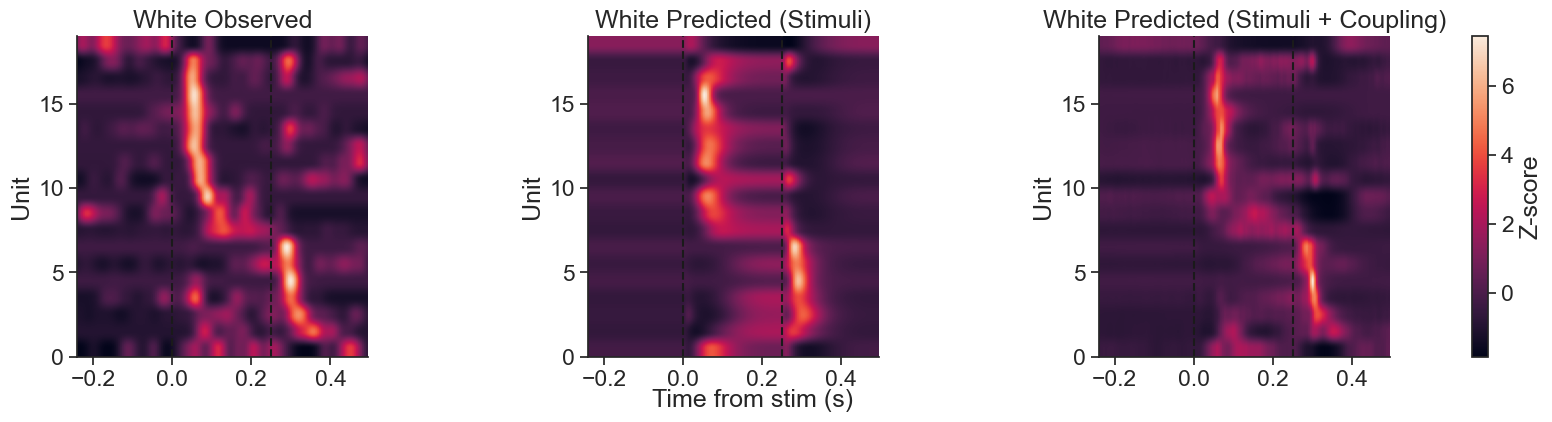

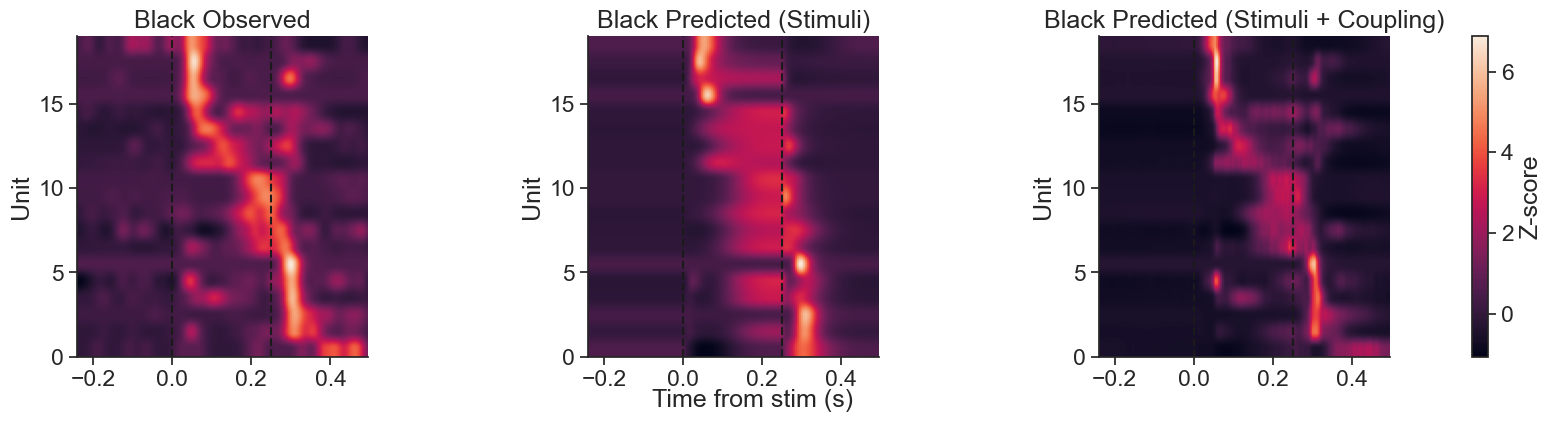

In [827]:
plot_zscores(dic_test, dic_pred_stimuli, dic_pred_coupling)

To the left of this plot we can see the observed z-scored activity, sorted by peak response time. In the middle, we can see the z-scored predictions of the model with Stimuli filters. To the right, we can see the z-scored predictions of the model with Stimuli and Coupling filters.

We can see that the average peak activity is much better captured by the new model, including the coupling filters. In particular, the Stimuli + Coupling model seems to produce less noisy predictions. This makes a lot of sense! Noise is shared across neurons, and the information of a single cell response is also encoded in the population activity, beyond the information provided by stimuli alone  <span id="cite1"></span> Pillow et al. (2008) <a href="#ref1">[1]</a>.

We can also compare the prediction of the Stimuli versus the Stimuli + Coupling model using a PETH:

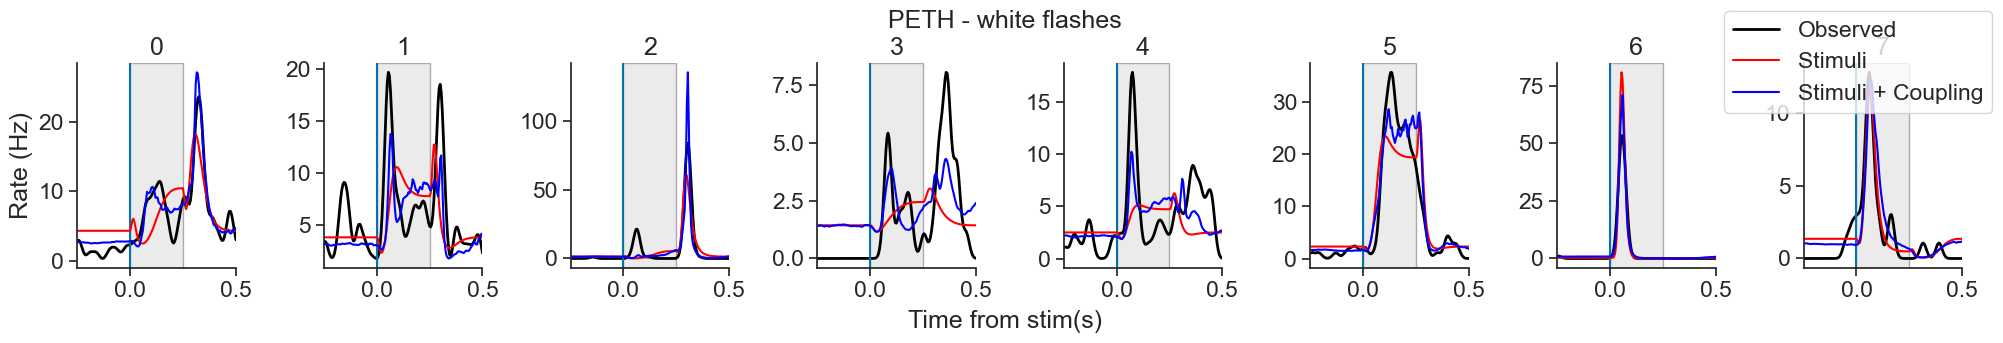

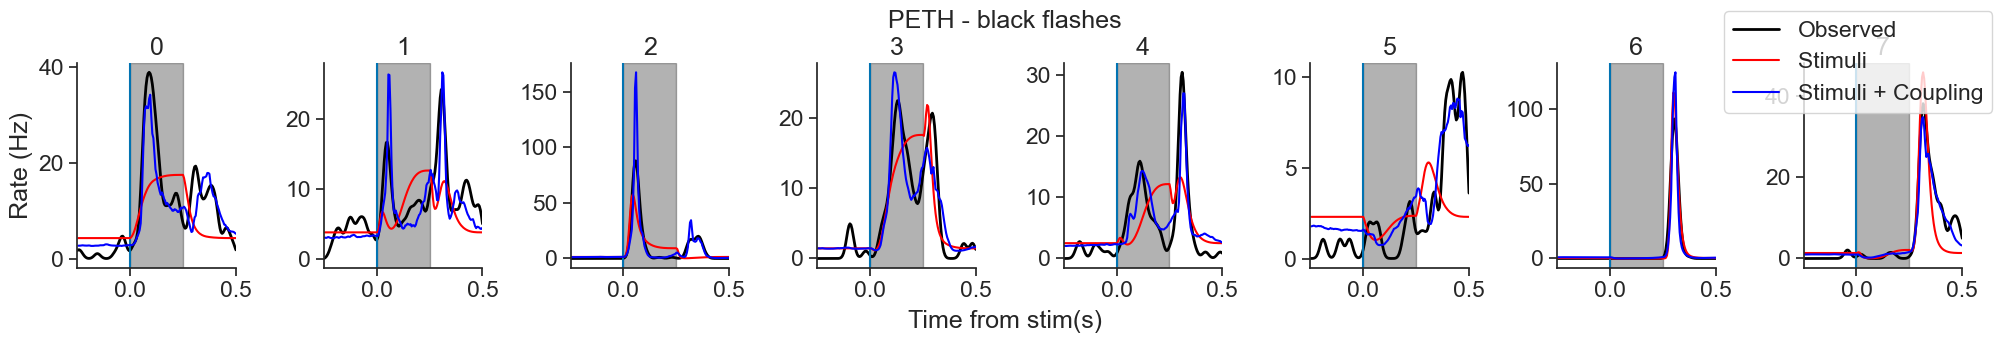

In [828]:
plot_pop_peth(
    peri_white_test, 
    "white", 
    bin_size,
    peri_pred_stimuli = ("Stimuli", "red", peri_white_pred),
    peri_pred_coupling = ("Stimuli + Coupling", "blue", peri_white_pred_coupling)
    )

plot_pop_peth(
    peri_black_test, 
    "black", 
    bin_size,
    peri_pred_stimuli = ("Stimuli", "red", peri_black_pred),
    peri_pred_coupling = ("Stimuli + Coupling", "blue", peri_black_pred_coupling)
    )

## Evaluate model performance quantitatively

Comparing the two models by examining their predictions is important, but you may also want a number with which to evaluate and compare your models’ performance. As discussed earlier, the GLM optimizes log-likelihood to find the best-fitting weights, and we can calculate this number using **NeMos** [```score```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.score.html#nemos.glm.PopulationGLM.score) method.

### Using log-likelihood

By default, [```score```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.score.html#nemos.glm.PopulationGLM.score) computes the mean log-likelihood. This function takes the following as required inputs:
- Predictors (in our case, our additive basis ```X_coupling_test```, which includes information of our black and white predictors, as well as the subset of units counts corresponding to the test set)
- Counts (in our case, ```units_counts_test```, because we wish to evaluate how good the model is at predicting unseen data)

In [829]:
# Calculate the mean score for the Stimuli + Coupling model
score_coupling = model_coupling.score(
    X_coupling_test,
    units_counts_test
)

print(score_coupling)

-0.090036154


We can also access each unit's score by adding a ```lambda``` function to the optional parameter [```aggregate_sample_scores```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.score.html#nemos.glm.PopulationGLM.score)

In [839]:
# Obtain individual units' scores
score_units = model_coupling.score(
    X_coupling_test, 
    units_counts_test, 
    aggregate_sample_scores=lambda x:np.mean(x,axis=0), 
)

print(score_units)

[-0.14070676 -0.12983197 -0.07299598 -0.06882325 -0.0850037  -0.09364977
 -0.03853203 -0.05853686 -0.1574271  -0.09744748 -0.1940306  -0.09533481
 -0.06536137 -0.10305484 -0.05298581 -0.05463077 -0.05696455 -0.09240121
 -0.05296794]


Now we can calculate the score separately for white and black flashes, and for both models (Stimuli and Stimuli + Coupling) using helper functions

In [ ]:
def evaluate_model(model, X, y, score_type="log-likelihood"):
    """
    Evaluate a model's performance at the population and unit levels.

    Parameters
    ----------
    model : object
        A model object that implements a `.score()` method with arguments `X`, `y`, and `score_type`.
    X : array-like or pynapple-compatible object
        Input features used for evaluation.
    y : array-like or pynapple-compatible object
        Target outputs corresponding to `X`.
    score_type : str, optional
        The scoring metric to use (e.g., "log-likelihood"). Passed to the model's `score` method.

    Returns
    -------
    score_pop : float
        The population-level score (aggregated across all units and samples).
    score_unit : np.ndarray
        The unit-level scores, computed by averaging over samples for each unit.
    """
    score_pop = model.score(
        X, 
        y, 
        score_type=score_type,
    )
    score_unit = model.score(
        X, 
        y, 
        aggregate_sample_scores=lambda x: np.mean(x, axis=0), 
        score_type=score_type,
    )
    return score_pop, score_unit

def evaluate_models_by_color(models, X_sets, y_sets, flashes_color, score_type="log-likelihood"):
    """
    Evaluate multiple models on a dataset filtered by flash color.

    Parameters
    ----------
    models : dict of str -> model
        Dictionary of model names and model objects to evaluate. Each model must implement `.score()`.
    X_sets : dict of str -> array-like or pynapple-compatible object
        Dictionary mapping model names to their corresponding input features.
    y_sets : array-like or pynapple-compatible object
        The target outputs to be used with all models.
    flashes_color : str
        The flash color condition used to restrict the data (e.g., "black" or "white").
    score_type : str, optional
        The scoring metric to use (e.g., "log-likelihood").

    Returns
    -------
    model_base_pop : float
        Population-level score of the first model in `models`.
    model_base_unit : np.ndarray
        Unit-level scores of the first model in `models`.
    model_hist_pop : float
        Population-level score of the second model in `models`.
    model_hist_unit : np.ndarray
        Unit-level scores of the second model in `models`.

    Notes
    -----
    The function assumes exactly two models in the `models` dictionary, 
    and returns their scores in fixed order based on insertion into the dictionary,
    first returning the population score, then the unit scores for each.

    """
    models_list = []
    for model_name, model in models.items():
        X = X_sets[model_name].restrict(flashes_color)
        y = y_sets.restrict(flashes_color)
        models_list.append(evaluate_model(model, X, y, score_type))
    return models_list[0][0], models_list[0][1], models_list[1][0], models_list[1][1]

In [832]:
# Define model dictionary
models = {
    "stimuli": model_stimuli,
    "coupling": model_coupling
}

# Calculate scores when predicting during white flashes
(score_white_stimuli_pop, 
 score_white_stimuli_unit, 
 score_white_coupling_pop,
 score_white_coupling_unit) = evaluate_models_by_color(
    models,
    {"stimuli": X_test, 
    "coupling": X_coupling_test},
    units_counts_test,
    flashes_test_white
)

# Calculate scores when predicting during black flashes
(score_black_stimuli_pop, 
 score_black_stimuli_unit, 
 score_black_coupling_pop,
 score_black_coupling_unit) = evaluate_models_by_color(
    models,
    {"stimuli": X_test, 
    "coupling": X_coupling_test},
    units_counts_test,
    flashes_test_black
)

After obtaining the scores, we can plot them (:

In [833]:
def plot_scores(scores, labels, score_method):
    # Plot as bar chart
    plt.figure(figsize=(7, 4))
    bars = plt.bar(labels, scores, color="skyblue", edgecolor='black')

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.001, 
                f"{height:.4f}", ha='center', va='bottom')

    plt.ylabel(f"{score_method}")
    plt.title("Model Scores by Condition")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

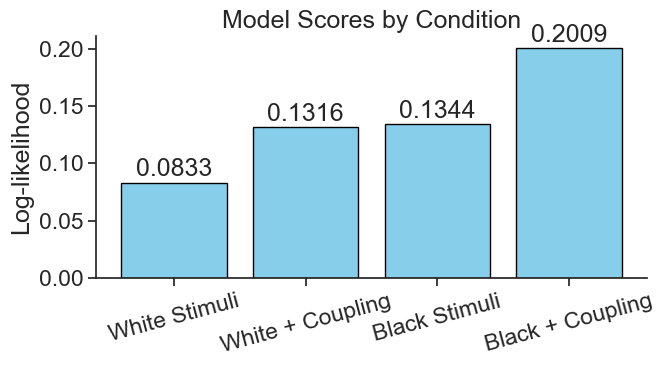

In [841]:
# List of scores
scores = [
    score_white_stimuli_pop,
    score_white_coupling_pop,
    score_black_stimuli_pop,
    score_black_coupling_pop
]

# Corresponding labels for each score
labels = [
    "White Stimuli",
    "White + Coupling",
    "Black Stimuli",
    "Black + Coupling"
]

# Plot
plot_scores(
    scores,
    labels,
    "Log-likelihood"
)

### Using pseudo-$R^2$ McFadden

The log-likelihood is un-normalized and thus doesn’t mean that much by itself, other than “higher = better”. When comparing alternative GLMs fit on the same dataset, whether that’s models using different regularizers and solvers or those using different predictors, comparing log-likelihoods is a reasonable thing to do.

Note that, because the log-likelihood is un-normalized, it should not be compared across datasets (because e.g., it won’t account for difference in noise levels). We provide the ability to compute the pseudo-$R^2$ for this purpose. For that, you only need to pass ```"pseudo-r2-McFadden"``` as ```score_type```:

::: {admonition} Why are we using ```pseudo-r2```? Why not just use standard $R^2$ as in linear regression?  
:class: info  
:class: dropdown  

In standard linear regression, model performance is often evaluated using the coefficient of determination, $R^2$, which represents the proportion of variance in the data explained by the model:

$$
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \mu)^2}
$$

Here:
- The numerator is the residual sum of squares (variance **not** explained by the model),
- The denominator is the total variance of the observations.

For instance, if a model only predicts the mean of the data (i.e., $\hat{y}_i = \mu$ for all $i$), then:

$$
R^2 = 1 - \frac{\sum_i (y_i - \mu)^2}{\sum_i (y_i - \mu)^2} = 0
$$

This means the model explains none of the variance beyond the baseline.

However, for GLMs, using $R^2$ is problematic for two key reasons:

1. Mean-variance relationship: in many GLMs, the variance is not constant but depends on the mean. For example, in a LNP model, a higher predicted firing rate implies a higher variance. This violates the assumption of *homoscedasticity* (constant variance) required for standard $R^2$ to be meaningful. As a result, even a model that predicts the mean accurately might appear to perform poorly under $R^2$ due to large, but expected, residuals.

2. Nonlinear link function: GLMs include a nonlinear transformation (link function) between the predictors and the mean of the observations. Because $R^2$ is derived under the assumption of a linear relationship, it no longer reflects the "proportion of explained variance" in a meaningful way when this assumption is violated.

To address these limitations, we use ```pseudo-r2```, which generalizes the concept of goodness-of-fit to non-Gaussian models. One common version is McFadden’s pseudo-$R^2$, defined as:

$$
R^2_{\text{McF}} = 1 - \frac{\log L_M}{\log L_0}
$$

Where:
- $\log L_M$ is the log-likelihood of the fitted model,
- $\log L_0$ is the log-likelihood of the null model (a model with only an intercept, i.e. predicting a constant mean).

This metric captures how much better the model is compared to simply predicting a constant mean, and can be interpreted as a *normalized log-likelihood*. Its values typically range between 0 and 1, but negative values can occur and may indicate poor fit or overfitting.

---

In this tutorial, we use McFadden’s pseudo-$R^2$  to evaluate model performance, as it is more appropriate for models like the LNP model used here.

For more details on implementation and additional scoring metrics, see the [**NeMos** documentation](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.PopulationGLM.score.html#nemos.glm.PopulationGLM.score).

:::


In [842]:
# Calculate the mean score for the Stimuli + Coupling model
# Using pseudo-r2-McFadden
score_coupling = model_coupling.score(
    X_coupling_test,
    units_counts_test,
    score_type = "pseudo-r2-McFadden"
)

print(score_coupling)

0.19085628


Same way as before, we can calculate the scores using our helper functions.

In [835]:
# Define model dictionary
models = {
    "stimuli": model_stimuli,
    "coupling": model_coupling
}

# Calculate scores when predicting during white flashes
(score_white_stimuli_pop, 
 score_white_stimuli_unit, 
 score_white_coupling_pop,
 score_white_coupling_unit) = evaluate_models_by_color(
    models,
    {"stimuli": X_test, 
    "coupling": X_coupling_test},
    units_counts_test,
    flashes_test_white,
    "pseudo-r2-McFadden"
)

# Calculate scores when predicting during black flashes
(score_black_stimuli_pop, 
 score_black_stimuli_unit, 
 score_black_coupling_pop,
 score_black_coupling_unit) = evaluate_models_by_color(
    models,
    {"stimuli": X_test, 
    "coupling": X_coupling_test},
    units_counts_test,
    flashes_test_black,
    "pseudo-r2-McFadden"
)

And plot the results

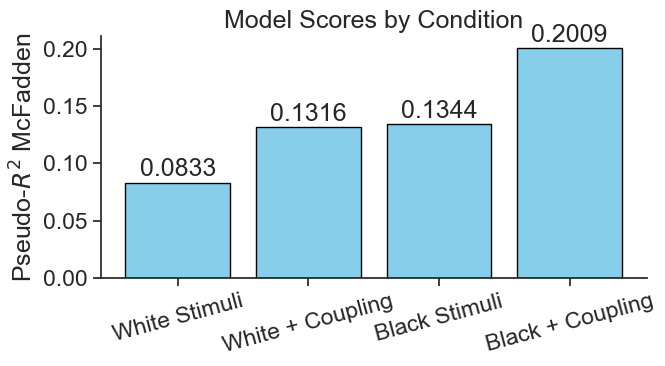

In [836]:
scores = [
    score_white_stimuli_pop,
    score_white_coupling_pop,
    score_black_stimuli_pop,
    score_black_coupling_pop
]

# Corresponding labels for each score
labels = [
    "White Stimuli",
    "White + Coupling",
    "Black Stimuli",
    "Black + Coupling"
]

plot_scores(
    scores,
    labels,
    "Pseudo-$R^2$ McFadden"
)

We can also see the individual scores for each unit!

In [864]:
def plot_unit_scores():
    # Combine all arrays into a list
    score_arrays = [
        score_white_stimuli_unit,
        score_white_coupling_unit,
        score_black_stimuli_unit,
        score_black_coupling_unit
    ]

    labels = ["White Stimuli", "White Stimuli + Coupling", "Black Stimuli", "Black Stimuli + Coupling"]
    num_conditions = len(score_arrays)
    num_units = len(score_white_stimuli_unit)

    # X positions for boxplots (centered)
    x_positions = np.arange(num_conditions)
    plt.figure(figsize=(17, 5))
    plt.tight_layout()

    # Plot boxplots
    plt.violinplot(
        score_arrays, 
        positions=x_positions, 
        widths=0.3,
        showmeans = True,
    )

    # Scatter individual dots (jittered) and connect lines
    for unit_idx in range(num_units):
        unit_scores = [arr[unit_idx] for arr in score_arrays]
        x_jittered = x_positions + np.random.normal(scale=0.01, size=num_conditions)
        
        # Scatter dots
        plt.scatter(x_jittered, unit_scores, color="black", s=10, alpha=0.7)

        # Connect dots for this unit
        plt.plot(x_jittered, unit_scores, color="black", alpha=0.2, linewidth=1)

    # X-axis labels
    plt.xticks(x_positions, labels)
    plt.ylabel("Pseudo-$R^2$ McFadden Score")
    plt.title("Unit scores across models and conditions")
    plt.show()

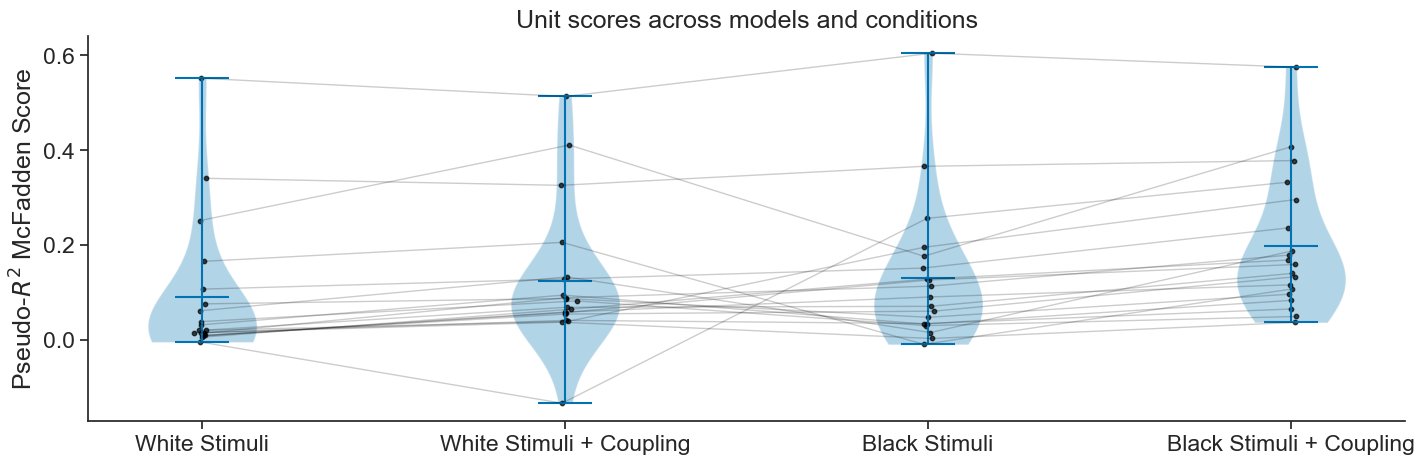

In [863]:
plot_unit_scores()

Although there is some variability between neurons, in general, the Stimuli + Coupling model is better at predicting spike trains than the model which only includes Stimuli filters. Moreover, it seems that our model is better at predicting activity ocurring as a response to Black flashes than as a response to White flashes.

## References
<a id="ref1"></a><a href="#cite1a">[1a]</a> <a href="#cite1b">[1b]</a> Pillow, J. W., Shlens, J., Paninski, L., Sher, A., Litke, A. M., Chichilnisky, E. J., & Simoncelli, E. P. (2008). Spatio-temporal correlations and visual signalling in a complete neuronal population. Nature, 454(7207), 995-999. https://doi.org/10.1038/nature07140

<a id="ref2"></a><a href="#cite2">[2]</a> Allen Institute for Brain Science. Allen Brain Observatory - Neuropixels Visual Coding - Technical White paper. Technical Report, Allen Institute for Brain Science, October 2019. https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/80/75/8075a100-ca64-429a-b39a-569121b612b2/neuropixels_visual_coding_-_white_paper_v10.pdf.

<a id="ref3"></a><a href="#cite3">[3]</a> Pillow, J. [Cosyne Talks]. (2018, March 1-4) Jonathan Pillow - Tutorial: Statistical models for neural data - Part 1 (Cosyne 2018) [Video]. Youtube. https://www.youtube.com/watch?v=NFeGW5ljUoI

<a id="ref4"></a><a href="#cite4">[4]</a>  Pillow, J. W., Paninski, L., Uzzell, V. J., Simoncelli, E. P., & Chichilnisky, E. J. (2005). Prediction and decoding of retinal ganglion cell responses with a probabilistic spiking model. The Journal of neuroscience : the official journal of the Society for Neuroscience, 25(47), 11003–11013. https://doi.org/10.1523/JNEUROSCI.3305-05.2005

## Data citation
The data used in this tutorial is from the Allen Brain Map, with the [following citation](https://knowledge.brain-map.org/data/4YYLRZZGK82FQ85NIH8):

Dataset: Allen Institute MindScope Program (2019). Allen Brain Observatory -- Neuropixels Visual Coding [Dataset]. Available from brain-map.org/explore/circuits

Primary publication: Siegle, J. H., Jia, X., Durand, S., et al. (2021). Survey of spiking in the mouse visual system reveals functional hierarchy. Nature, 592(7612), 86-92. https://doi.org/10.1038/s41586-020-03171-x
